In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Heatmap_Players_MAE_on_Pitch_Baseline_Model**

## **Tested_on_Baseline**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import drive
from matplotlib.patches import Circle, Arc

print("== STEP 1: PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Baseline"
heatmap_all_path = os.path.join(output_dir, "MAE_Heatmap_All_Players_Baseline.png")
heatmap_possession_path = os.path.join(output_dir, "MAE_Heatmap_Possession_Team_Baseline.png")
heatmap_opponent_path = os.path.join(output_dir, "MAE_Heatmap_Opponent_Team_Baseline.png")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Heatmap (All Players) path: {heatmap_all_path}")
print(f"Heatmap (Possession Team) path: {heatmap_possession_path}")
print(f"Heatmap (Opponent Team) path: {heatmap_opponent_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'playerid': 'int32'
}

# Load only required columns
players_df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'playerid', 'team'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ Players CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {players_df.shape[0]:,} rows, {players_df.shape[1]} columns")
print(f"   ✅ Memory usage: {players_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter data for timestep 5 (prediction timestep)
print("\n🔍 Filtering data for timestep 5...")
start_filter = time.time()
t5_df = players_df[players_df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {t5_df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
sequences = t5_df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in t5_df.groupby('global_sequence_id'):
    # Check structure (22 actual + 22 predicted)
    actual_data = group[group['is_predicted'] == 0]
    predicted_data = group[group['is_predicted'] == 1]

    if len(actual_data) == 22 and len(predicted_data) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {sequences - len(valid_sequences):,}")

# Define PITCH DIMENSIONS BASED ON OFFICIAL FOOTBALL PITCH (105m x 68m)
pitch_x_min, pitch_x_max = -52.5, 52.5  # Total length 105 units (meters)
pitch_y_min, pitch_y_max = -34.0, 34.0  # Total width 68 units (meters)
grid_x_bins = 21  # 5 units per bin (105/5 = 21)
grid_y_bins = 14  # ~4.86 units per bin (68/14 ≈ 4.86)

# Create grid for heatmap
print("\n🧮 Creating pitch position MAE heatmap with accurate pitch dimensions...")
start_heatmap = time.time()

# Initialize grid arrays for all players, possession team, and opponent team
mae_grid_all = np.zeros((grid_y_bins, grid_x_bins))
count_grid_all = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_possession = np.zeros((grid_y_bins, grid_x_bins))
count_grid_possession = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))
count_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))

# Create grid edges for x and y
x_edges = np.linspace(pitch_x_min, pitch_x_max, grid_x_bins + 1)
y_edges = np.linspace(pitch_y_min, pitch_y_max, grid_y_bins + 1)

# Calculate overall MAE across all players and sequences (single value)
all_mae_values = []

# Process each valid sequence
print(f"   • Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = t5_df[t5_df['global_sequence_id'] == seq_id]

    # Separate actual and predicted positions
    actual_data = seq_data[seq_data['is_predicted'] == 0]
    predicted_data = seq_data[seq_data['is_predicted'] == 1]

    # Sort actual and predicted data to preserve player order within sequence
    actual_data = actual_data.sort_values('playerid')
    predicted_data = predicted_data.sort_values('playerid')

    # Merge actual and predicted data on playerid
    merged_data = pd.merge(
        actual_data,
        predicted_data,
        on=['global_sequence_id', 'timestep', 'playerid', 'team'],
        suffixes=('_actual', '_predicted')
    )

    # Add team type based on position in sequence (first 11 = possession, next 11 = opponent)
    merged_data['team_type'] = 'possession'
    merged_data.iloc[11:, merged_data.columns.get_loc('team_type')] = 'opponent'

    # Calculate MAE for each player
    merged_data['mae'] = (abs(merged_data['x_actual'] - merged_data['x_predicted']) +
                          abs(merged_data['y_actual'] - merged_data['y_predicted'])) / 2

    # Store all MAE values for overall calculation
    all_mae_values.extend(merged_data['mae'].tolist())

    # Process each player position
    for _, row in merged_data.iterrows():
        x = row['x_actual']
        y = row['y_actual']
        mae = row['mae']

        # Find grid cell
        x_idx = np.digitize(x, x_edges) - 1
        y_idx = np.digitize(y, y_edges) - 1

        # Ensure indices are within bounds
        if 0 <= x_idx < grid_x_bins and 0 <= y_idx < grid_y_bins:
            # Update all players grid
            mae_grid_all[y_idx, x_idx] += mae
            count_grid_all[y_idx, x_idx] += 1

            # Update team-specific grids
            if row['team_type'] == 'possession':
                mae_grid_possession[y_idx, x_idx] += mae
                count_grid_possession[y_idx, x_idx] += 1
            else:  # opponent team
                mae_grid_opponent[y_idx, x_idx] += mae
                count_grid_opponent[y_idx, x_idx] += 1

# Calculate average MAE for each cell
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mae_grid_all = np.where(count_grid_all > 0, mae_grid_all / count_grid_all, np.nan)
    avg_mae_grid_possession = np.where(count_grid_possession > 0, mae_grid_possession / count_grid_possession, np.nan)
    avg_mae_grid_opponent = np.where(count_grid_opponent > 0, mae_grid_opponent / count_grid_opponent, np.nan)

# Set minimum count threshold for reliable data
min_count = 10
avg_mae_grid_all[count_grid_all < min_count] = np.nan
avg_mae_grid_possession[count_grid_possession < min_count] = np.nan
avg_mae_grid_opponent[count_grid_opponent < min_count] = np.nan

# Calculate the overall MAE across ALL players and sequences (single value)
overall_mae = np.mean(all_mae_values) if all_mae_values else 0.0

heatmap_time = time.time() - start_heatmap
print(f"   ✅ Heatmap data calculated in {heatmap_time:.2f} seconds")

# Create visualization
print("\n🎨 Generating heatmap visualizations...")
start_viz = time.time()

# Function to draw pitch markings with ACCURATE DIMENSIONS
def draw_pitch(ax, x_min=-52.5, x_max=52.5, y_min=-34.0, y_max=34.0):
    """Draw standard football pitch markings with accurate dimensions"""
    # Pitch boundary
    ax.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min], color='white', linewidth=2)

    # Center line
    ax.plot([0, 0], [y_min, y_max], color='white', linewidth=1, linestyle='--')

    # Center circle (radius 9.15m)
    center_circle = Circle((0, 0), 9.15, color='white', fill=False, linewidth=1)
    ax.add_patch(center_circle)

    # Penalty areas (width 40.32m, depth 16.5m)
    # Left penalty area (team H)
    ax.plot([x_min + 16.5, x_min + 16.5, x_min, x_min],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Left penalty arc (radius 9.15m, centered 11m from goal)
    left_penalty_arc = Arc((x_min + 11.0, 0), 18.3, 18.3, angle=0, theta1=306, theta2=54, color='white', linewidth=1)
    ax.add_patch(left_penalty_arc)

    # Right penalty area (team A)
    ax.plot([x_max - 16.5, x_max - 16.5, x_max, x_max],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Right penalty arc (radius 9.15m, centered 11m from goal)
    right_penalty_arc = Arc((x_max - 11.0, 0), 18.3, 18.3, angle=0, theta1=126, theta2=234, color='white', linewidth=1)
    ax.add_patch(right_penalty_arc)

    # Goal areas (width 18.32m, depth 5.5m)
    # Left goal area
    ax.plot([x_min + 5.5, x_min + 5.5, x_min, x_min],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Right goal area
    ax.plot([x_max - 5.5, x_max - 5.5, x_max, x_max],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Center spot
    ax.add_patch(Circle((0, 0), 0.5, color='white'))

    # Penalty spots (11m from goal line)
    ax.add_patch(Circle((x_min + 11.0, 0), 0.5, color='white'))
    ax.add_patch(Circle((x_max - 11.0, 0), 0.5, color='white'))

    # Corner arcs (radius 1m)
    ax.add_patch(Arc((x_min, y_min), 2, 2, angle=0, theta1=0, theta2=90, color='white', linewidth=1))
    ax.add_patch(Arc((x_min, y_max), 2, 2, angle=0, theta1=270, theta2=360, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_min), 2, 2, angle=0, theta1=90, theta2=180, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_max), 2, 2, angle=0, theta1=180, theta2=270, color='white', linewidth=1))

# Create color map with perceptually uniform gradient
cmap = plt.cm.viridis

# Function to create and save a heatmap
def create_heatmap(avg_mae_grid, count_grid, title, output_path, min_count=10):
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Create masked array for cells with insufficient data
    masked_mae = np.ma.masked_invalid(avg_mae_grid)
    masked_mae = np.ma.masked_where(count_grid < min_count, masked_mae)

    # Determine color scale range (excluding outliers)
    valid_values = avg_mae_grid[count_grid >= min_count]
    if len(valid_values) > 0:
        vmin = np.percentile(valid_values, 5)
        vmax = np.percentile(valid_values, 95)
    else:
        vmin, vmax = 0, 1

    # Plot heatmap
    im = ax.imshow(
        masked_mae,
        origin='lower',
        extent=[pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.85
    )

    # Add pitch markings
    draw_pitch(ax, pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max)

    # Set title and labels
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('X Position (meters)', fontsize=14, labelpad=10)
    plt.ylabel('Y Position (meters)', fontsize=14, labelpad=10)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('MAE (Mean Absolute Error)', fontsize=14)

    # Add data reliability note
    plt.figtext(
        0.5, 0.01,
        f"Note: Only cells with at least {min_count} data points are shown.\n"
        "MAE = (|x_error| + |y_error|) / 2 for each player position.\n"
        "Data: Baseline model trained on multiple teams, FIFA 2022\n"
        f"Overall MAE across all players and sequences: {overall_mae:.3f} units",
        ha="center",
        fontsize=10,
        color="gray"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1])

    # Save figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

# Create and save all heatmaps
create_heatmap(
    avg_mae_grid_all,
    count_grid_all,
    "Player Position MAE Heatmap (All Players)",
    heatmap_all_path
)
print(f"   ✅ All Players heatmap saved to: {heatmap_all_path}")

create_heatmap(
    avg_mae_grid_possession,
    count_grid_possession,
    "Player Position MAE Heatmap (Possession Team)",
    heatmap_possession_path
)
print(f"   ✅ Possession Team heatmap saved to: {heatmap_possession_path}")

create_heatmap(
    avg_mae_grid_opponent,
    count_grid_opponent,
    "Player Position MAE Heatmap (Opponent Team)",
    heatmap_opponent_path
)
print(f"   ✅ Opponent Team heatmap saved to: {heatmap_opponent_path}")

viz_time = time.time() - start_viz
print(f"   ✅ Heatmap visualizations generated in {viz_time:.2f} seconds")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Pitch dimensions: {pitch_x_min} to {pitch_x_max} (X), {pitch_y_min} to {pitch_y_max} (Y)")
print(f"   • Grid resolution: {grid_x_bins} x {grid_y_bins} cells")
print(f"   • Minimum data points per cell: {min_count}")
print(f"   • Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print(f"   • Overall average MAE (grid-based): {np.nanmean(avg_mae_grid_all):.3f} units")
print(f"   • Possession team average MAE: {np.nanmean(avg_mae_grid_possession):.3f} units")
print(f"   • Opponent team average MAE: {np.nanmean(avg_mae_grid_opponent):.3f} units")

# Find areas with highest and lowest MAE
valid_all = avg_mae_grid_all[~np.isnan(avg_mae_grid_all)]
if len(valid_all) > 0:
    min_mae_idx = np.unravel_index(np.nanargmin(avg_mae_grid_all), avg_mae_grid_all.shape)
    max_mae_idx = np.unravel_index(np.nanargmax(avg_mae_grid_all), avg_mae_grid_all.shape)

    min_x = (x_edges[min_mae_idx[1]] + x_edges[min_mae_idx[1] + 1]) / 2
    min_y = (y_edges[min_mae_idx[0]] + y_edges[min_mae_idx[0] + 1]) / 2
    max_x = (x_edges[max_mae_idx[1]] + x_edges[max_mae_idx[1] + 1]) / 2
    max_y = (y_edges[max_mae_idx[0]] + y_edges[max_mae_idx[0] + 1]) / 2

    print(f"   • Lowest MAE area: X={min_x:.1f}m, Y={min_y:.1f}m (MAE={np.nanmin(avg_mae_grid_all):.3f})")
    print(f"   • Highest MAE area: X={max_x:.1f}m, Y={max_y:.1f}m (MAE={np.nanmax(avg_mae_grid_all):.3f})")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Pitch position MAE heatmap analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze heatmap results to identify spatial patterns in prediction accuracy")
print("Note: Heatmaps show prediction error (MAE) across the football pitch")
print("      Blue areas = Low prediction error (good accuracy)")
print("      Red areas = High prediction error (poor accuracy)")
print("      Only cells with sufficient data points are displayed")
print("      Pitch markings overlaid for spatial context")
print(f"      Note: Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print("      Note: Goalkeeper areas often show higher prediction error")
print("      Note: Central midfield areas often show lower prediction error")
print("      Note: Team orientation: Team H attacks from left to right")
print("      Note: First 11 players in each sequence = possession team")
print("      Note: Next 11 players in each sequence = opponent team")
print("      Note: Using accurate pitch dimensions (105m x 68m)")
print("      Note: X-axis: -52.5 to 52.5 (total 105m)")
print("      Note: Y-axis: -34.0 to 34.0 (total 68m)")
print("      Note: Penalty areas at x = ±36.0 to ±52.5")
print("      Note: Goal areas at x = ±47.0 to ±52.5")
print("      Note: Penalty spots at x = ±41.0")

== STEP 1: PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Baseline
Heatmap (All Players) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Baseline/MAE_Heatmap_All_Players_Baseline.png
Heatmap (Possession Team) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Baseline/MAE_Heatmap_Possession_Team_Baseline.png
Heatmap (Opp

## **Tested on France**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import drive
from matplotlib.patches import Circle, Arc

print("== STEP 1: FRANCE PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/France"
heatmap_all_path = os.path.join(output_dir, "MAE_Heatmap_All_Players_France.png")
heatmap_possession_path = os.path.join(output_dir, "MAE_Heatmap_Possession_Team_France.png")
heatmap_opponent_path = os.path.join(output_dir, "MAE_Heatmap_Opponent_Team_France.png")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Heatmap (All Players) path: {heatmap_all_path}")
print(f"Heatmap (Possession Team) path: {heatmap_possession_path}")
print(f"Heatmap (Opponent Team) path: {heatmap_opponent_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading France players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'playerid': 'int32'
}

# Load only required columns
players_df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'playerid', 'team'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ Players CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {players_df.shape[0]:,} rows, {players_df.shape[1]} columns")
print(f"   ✅ Memory usage: {players_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter data for timestep 5 (prediction timestep)
print("\n🔍 Filtering data for timestep 5...")
start_filter = time.time()
t5_df = players_df[players_df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {t5_df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
sequences = t5_df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in t5_df.groupby('global_sequence_id'):
    # Check structure (22 actual + 22 predicted)
    actual_data = group[group['is_predicted'] == 0]
    predicted_data = group[group['is_predicted'] == 1]

    if len(actual_data) == 22 and len(predicted_data) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {sequences - len(valid_sequences):,}")

# Define PITCH DIMENSIONS BASED ON OFFICIAL FOOTBALL PITCH (105m x 68m)
pitch_x_min, pitch_x_max = -52.5, 52.5  # Total length 105 units (meters)
pitch_y_min, pitch_y_max = -34.0, 34.0  # Total width 68 units (meters)
grid_x_bins = 21  # 5 units per bin (105/5 = 21)
grid_y_bins = 14  # ~4.86 units per bin (68/14 ≈ 4.86)

# Create grid for heatmap
print("\n🧮 Creating France pitch position MAE heatmap with accurate pitch dimensions...")
start_heatmap = time.time()

# Initialize grid arrays for all players, possession team, and opponent team
mae_grid_all = np.zeros((grid_y_bins, grid_x_bins))
count_grid_all = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_possession = np.zeros((grid_y_bins, grid_x_bins))
count_grid_possession = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))
count_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))

# Create grid edges for x and y
x_edges = np.linspace(pitch_x_min, pitch_x_max, grid_x_bins + 1)
y_edges = np.linspace(pitch_y_min, pitch_y_max, grid_y_bins + 1)

# Calculate overall MAE across all players and sequences (single value)
all_mae_values = []

# Process each valid sequence
print(f"   • Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = t5_df[t5_df['global_sequence_id'] == seq_id]

    # Separate actual and predicted positions
    actual_data = seq_data[seq_data['is_predicted'] == 0]
    predicted_data = seq_data[seq_data['is_predicted'] == 1]

    # Sort actual and predicted data to preserve player order within sequence
    actual_data = actual_data.sort_values('playerid')
    predicted_data = predicted_data.sort_values('playerid')

    # Merge actual and predicted data on playerid
    merged_data = pd.merge(
        actual_data,
        predicted_data,
        on=['global_sequence_id', 'timestep', 'playerid', 'team'],
        suffixes=('_actual', '_predicted')
    )

    # Add team type based on position in sequence (first 11 = possession, next 11 = opponent)
    merged_data['team_type'] = 'possession'
    merged_data.iloc[11:, merged_data.columns.get_loc('team_type')] = 'opponent'

    # Calculate MAE for each player
    merged_data['mae'] = (abs(merged_data['x_actual'] - merged_data['x_predicted']) +
                          abs(merged_data['y_actual'] - merged_data['y_predicted'])) / 2

    # Store all MAE values for overall calculation
    all_mae_values.extend(merged_data['mae'].tolist())

    # Process each player position
    for _, row in merged_data.iterrows():
        x = row['x_actual']
        y = row['y_actual']
        mae = row['mae']

        # Find grid cell
        x_idx = np.digitize(x, x_edges) - 1
        y_idx = np.digitize(y, y_edges) - 1

        # Ensure indices are within bounds
        if 0 <= x_idx < grid_x_bins and 0 <= y_idx < grid_y_bins:
            # Update all players grid
            mae_grid_all[y_idx, x_idx] += mae
            count_grid_all[y_idx, x_idx] += 1

            # Update team-specific grids
            if row['team_type'] == 'possession':
                mae_grid_possession[y_idx, x_idx] += mae
                count_grid_possession[y_idx, x_idx] += 1
            else:  # opponent team
                mae_grid_opponent[y_idx, x_idx] += mae
                count_grid_opponent[y_idx, x_idx] += 1

# Calculate average MAE for each cell
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mae_grid_all = np.where(count_grid_all > 0, mae_grid_all / count_grid_all, np.nan)
    avg_mae_grid_possession = np.where(count_grid_possession > 0, mae_grid_possession / count_grid_possession, np.nan)
    avg_mae_grid_opponent = np.where(count_grid_opponent > 0, mae_grid_opponent / count_grid_opponent, np.nan)

# Set minimum count threshold for reliable data
min_count = 10
avg_mae_grid_all[count_grid_all < min_count] = np.nan
avg_mae_grid_possession[count_grid_possession < min_count] = np.nan
avg_mae_grid_opponent[count_grid_opponent < min_count] = np.nan

# Calculate the overall MAE across ALL players and sequences (single value)
overall_mae = np.mean(all_mae_values) if all_mae_values else 0.0

heatmap_time = time.time() - start_heatmap
print(f"   ✅ Heatmap data calculated in {heatmap_time:.2f} seconds")

# Create visualization
print("\n🎨 Generating France heatmap visualizations...")
start_viz = time.time()

# Function to draw pitch markings with ACCURATE DIMENSIONS
def draw_pitch(ax, x_min=-52.5, x_max=52.5, y_min=-34.0, y_max=34.0):
    """Draw standard football pitch markings with accurate dimensions"""
    # Pitch boundary
    ax.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min], color='white', linewidth=2)

    # Center line
    ax.plot([0, 0], [y_min, y_max], color='white', linewidth=1, linestyle='--')

    # Center circle (radius 9.15m)
    center_circle = Circle((0, 0), 9.15, color='white', fill=False, linewidth=1)
    ax.add_patch(center_circle)

    # Penalty areas (width 40.32m, depth 16.5m)
    # Left penalty area (team H)
    ax.plot([x_min + 16.5, x_min + 16.5, x_min, x_min],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Left penalty arc (radius 9.15m, centered 11m from goal)
    left_penalty_arc = Arc((x_min + 11.0, 0), 18.3, 18.3, angle=0, theta1=306, theta2=54, color='white', linewidth=1)
    ax.add_patch(left_penalty_arc)

    # Right penalty area (team A)
    ax.plot([x_max - 16.5, x_max - 16.5, x_max, x_max],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Right penalty arc (radius 9.15m, centered 11m from goal)
    right_penalty_arc = Arc((x_max - 11.0, 0), 18.3, 18.3, angle=0, theta1=126, theta2=234, color='white', linewidth=1)
    ax.add_patch(right_penalty_arc)

    # Goal areas (width 18.32m, depth 5.5m)
    # Left goal area
    ax.plot([x_min + 5.5, x_min + 5.5, x_min, x_min],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Right goal area
    ax.plot([x_max - 5.5, x_max - 5.5, x_max, x_max],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Center spot
    ax.add_patch(Circle((0, 0), 0.5, color='white'))

    # Penalty spots (11m from goal line)
    ax.add_patch(Circle((x_min + 11.0, 0), 0.5, color='white'))
    ax.add_patch(Circle((x_max - 11.0, 0), 0.5, color='white'))

    # Corner arcs (radius 1m)
    ax.add_patch(Arc((x_min, y_min), 2, 2, angle=0, theta1=0, theta2=90, color='white', linewidth=1))
    ax.add_patch(Arc((x_min, y_max), 2, 2, angle=0, theta1=270, theta2=360, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_min), 2, 2, angle=0, theta1=90, theta2=180, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_max), 2, 2, angle=0, theta1=180, theta2=270, color='white', linewidth=1))

# Create color map with perceptually uniform gradient
cmap = plt.cm.viridis

# Function to create and save a heatmap
def create_heatmap(avg_mae_grid, count_grid, title, output_path, min_count=10):
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Create masked array for cells with insufficient data
    masked_mae = np.ma.masked_invalid(avg_mae_grid)
    masked_mae = np.ma.masked_where(count_grid < min_count, masked_mae)

    # Determine color scale range (excluding outliers)
    valid_values = avg_mae_grid[count_grid >= min_count]
    if len(valid_values) > 0:
        vmin = np.percentile(valid_values, 5)
        vmax = np.percentile(valid_values, 95)
    else:
        vmin, vmax = 0, 1

    # Plot heatmap
    im = ax.imshow(
        masked_mae,
        origin='lower',
        extent=[pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.85
    )

    # Add pitch markings
    draw_pitch(ax, pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max)

    # Set title and labels
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('X Position (meters)', fontsize=14, labelpad=10)
    plt.ylabel('Y Position (meters)', fontsize=14, labelpad=10)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('MAE (Mean Absolute Error)', fontsize=14)

    # Add data reliability note
    plt.figtext(
        0.5, 0.01,
        f"Note: Only cells with at least {min_count} data points are shown.\n"
        "MAE = (|x_error| + |y_error|) / 2 for each player position.\n"
        "Data: France test set evaluated on baseline model, FIFA 2022\n"
        f"Overall MAE across all players and sequences: {overall_mae:.3f} units",
        ha="center",
        fontsize=10,
        color="gray"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1])

    # Save figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

# Create and save all heatmaps
create_heatmap(
    avg_mae_grid_all,
    count_grid_all,
    "France Player Position MAE Heatmap (All Players)",
    heatmap_all_path
)
print(f"   ✅ All Players heatmap saved to: {heatmap_all_path}")

create_heatmap(
    avg_mae_grid_possession,
    count_grid_possession,
    "France Player Position MAE Heatmap (Possession Team)",
    heatmap_possession_path
)
print(f"   ✅ Possession Team heatmap saved to: {heatmap_possession_path}")

create_heatmap(
    avg_mae_grid_opponent,
    count_grid_opponent,
    "France Player Position MAE Heatmap (Opponent Team)",
    heatmap_opponent_path
)
print(f"   ✅ Opponent Team heatmap saved to: {heatmap_opponent_path}")

viz_time = time.time() - start_viz
print(f"   ✅ Heatmap visualizations generated in {viz_time:.2f} seconds")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Pitch dimensions: {pitch_x_min} to {pitch_x_max} (X), {pitch_y_min} to {pitch_y_max} (Y)")
print(f"   • Grid resolution: {grid_x_bins} x {grid_y_bins} cells")
print(f"   • Minimum data points per cell: {min_count}")
print(f"   • Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print(f"   • Overall average MAE (grid-based): {np.nanmean(avg_mae_grid_all):.3f} units")
print(f"   • Possession team average MAE: {np.nanmean(avg_mae_grid_possession):.3f} units")
print(f"   • Opponent team average MAE: {np.nanmean(avg_mae_grid_opponent):.3f} units")

# Find areas with highest and lowest MAE
valid_all = avg_mae_grid_all[~np.isnan(avg_mae_grid_all)]
if len(valid_all) > 0:
    min_mae_idx = np.unravel_index(np.nanargmin(avg_mae_grid_all), avg_mae_grid_all.shape)
    max_mae_idx = np.unravel_index(np.nanargmax(avg_mae_grid_all), avg_mae_grid_all.shape)

    min_x = (x_edges[min_mae_idx[1]] + x_edges[min_mae_idx[1] + 1]) / 2
    min_y = (y_edges[min_mae_idx[0]] + y_edges[min_mae_idx[0] + 1]) / 2
    max_x = (x_edges[max_mae_idx[1]] + x_edges[max_mae_idx[1] + 1]) / 2
    max_y = (y_edges[max_mae_idx[0]] + y_edges[max_mae_idx[0] + 1]) / 2

    print(f"   • Lowest MAE area: X={min_x:.1f}m, Y={min_y:.1f}m (MAE={np.nanmin(avg_mae_grid_all):.3f})")
    print(f"   • Highest MAE area: X={max_x:.1f}m, Y={max_y:.1f}m (MAE={np.nanmax(avg_mae_grid_all):.3f})")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: France pitch position MAE heatmap analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze heatmap results to identify spatial patterns in prediction accuracy")
print("Note: Heatmaps show prediction error (MAE) across the football pitch")
print("      Blue areas = Low prediction error (good accuracy)")
print("      Red areas = High prediction error (poor accuracy)")
print("      Only cells with sufficient data points are displayed")
print("      Pitch markings overlaid for spatial context")
print(f"      Note: Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print("      Note: Goalkeeper areas often show higher prediction error")
print("      Note: Central midfield areas often show lower prediction error")
print("      Note: Team orientation: Team H attacks from left to right")
print("      Note: First 11 players in each sequence = possession team")
print("      Note: Next 11 players in each sequence = opponent team")
print("      Note: Using accurate pitch dimensions (105m x 68m)")
print("      Note: X-axis: -52.5 to 52.5 (total 105m)")
print("      Note: Y-axis: -34.0 to 34.0 (total 68m)")
print("      Note: Penalty areas at x = ±36.0 to ±52.5")
print("      Note: Goal areas at x = ±47.0 to ±52.5")
print("      Note: Penalty spots at x = ±41.0")
print("      Note: France-specific analysis using France test data")

== STEP 1: FRANCE PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/France_Test/predictions/predicted_players_france.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/France
Heatmap (All Players) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/France/MAE_Heatmap_All_Players_France.png
Heatmap (Possession Team) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/France/MAE_Heatmap_Possession_Team_France.p

## **Tested on Morocco**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import drive
from matplotlib.patches import Circle, Arc

print("== STEP 1: MOROCCO PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Morocco"
heatmap_all_path = os.path.join(output_dir, "MAE_Heatmap_All_Players_Morocco.png")
heatmap_possession_path = os.path.join(output_dir, "MAE_Heatmap_Possession_Team_Morocco.png")
heatmap_opponent_path = os.path.join(output_dir, "MAE_Heatmap_Opponent_Team_Morocco.png")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Output directory: {output_dir}")
print(f"Heatmap (All Players) path: {heatmap_all_path}")
print(f"Heatmap (Possession Team) path: {heatmap_possession_path}")
print(f"Heatmap (Opponent Team) path: {heatmap_opponent_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Morocco players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'playerid': 'int32'
}

# Load only required columns
players_df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'playerid', 'team'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ Players CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {players_df.shape[0]:,} rows, {players_df.shape[1]} columns")
print(f"   ✅ Memory usage: {players_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter data for timestep 5 (prediction timestep)
print("\n🔍 Filtering data for timestep 5...")
start_filter = time.time()
t5_df = players_df[players_df['timestep'] == 5].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {t5_df.shape[0]:,} (timestep 5 only)")

# Verify data structure
print("\n🔍 Verifying data structure...")
sequences = t5_df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in t5_df.groupby('global_sequence_id'):
    # Check structure (22 actual + 22 predicted)
    actual_data = group[group['is_predicted'] == 0]
    predicted_data = group[group['is_predicted'] == 1]

    if len(actual_data) == 22 and len(predicted_data) == 22:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {sequences - len(valid_sequences):,}")

# Define PITCH DIMENSIONS BASED ON OFFICIAL FOOTBALL PITCH (105m x 68m)
pitch_x_min, pitch_x_max = -52.5, 52.5  # Total length 105 units (meters)
pitch_y_min, pitch_y_max = -34.0, 34.0  # Total width 68 units (meters)
grid_x_bins = 21  # 5 units per bin (105/5 = 21)
grid_y_bins = 14  # ~4.86 units per bin (68/14 ≈ 4.86)

# Create grid for heatmap
print("\n🧮 Creating Morocco pitch position MAE heatmap with accurate pitch dimensions...")
start_heatmap = time.time()

# Initialize grid arrays for all players, possession team, and opponent team
mae_grid_all = np.zeros((grid_y_bins, grid_x_bins))
count_grid_all = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_possession = np.zeros((grid_y_bins, grid_x_bins))
count_grid_possession = np.zeros((grid_y_bins, grid_x_bins))

mae_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))
count_grid_opponent = np.zeros((grid_y_bins, grid_x_bins))

# Create grid edges for x and y
x_edges = np.linspace(pitch_x_min, pitch_x_max, grid_x_bins + 1)
y_edges = np.linspace(pitch_y_min, pitch_y_max, grid_y_bins + 1)

# Calculate overall MAE across all players and sequences (single value)
all_mae_values = []

# Process each valid sequence
print(f"   • Processing {len(valid_sequences):,} valid sequences...")
for seq_id in valid_sequences:
    # Extract sequence data
    seq_data = t5_df[t5_df['global_sequence_id'] == seq_id]

    # Separate actual and predicted positions
    actual_data = seq_data[seq_data['is_predicted'] == 0]
    predicted_data = seq_data[seq_data['is_predicted'] == 1]

    # Sort actual and predicted data to preserve player order within sequence
    actual_data = actual_data.sort_values('playerid')
    predicted_data = predicted_data.sort_values('playerid')

    # Merge actual and predicted data on playerid
    merged_data = pd.merge(
        actual_data,
        predicted_data,
        on=['global_sequence_id', 'timestep', 'playerid', 'team'],
        suffixes=('_actual', '_predicted')
    )

    # Add team type based on position in sequence (first 11 = possession, next 11 = opponent)
    merged_data['team_type'] = 'possession'
    merged_data.iloc[11:, merged_data.columns.get_loc('team_type')] = 'opponent'

    # Calculate MAE for each player
    merged_data['mae'] = (abs(merged_data['x_actual'] - merged_data['x_predicted']) +
                          abs(merged_data['y_actual'] - merged_data['y_predicted'])) / 2

    # Store all MAE values for overall calculation
    all_mae_values.extend(merged_data['mae'].tolist())

    # Process each player position
    for _, row in merged_data.iterrows():
        x = row['x_actual']
        y = row['y_actual']
        mae = row['mae']

        # Find grid cell
        x_idx = np.digitize(x, x_edges) - 1
        y_idx = np.digitize(y, y_edges) - 1

        # Ensure indices are within bounds
        if 0 <= x_idx < grid_x_bins and 0 <= y_idx < grid_y_bins:
            # Update all players grid
            mae_grid_all[y_idx, x_idx] += mae
            count_grid_all[y_idx, x_idx] += 1

            # Update team-specific grids
            if row['team_type'] == 'possession':
                mae_grid_possession[y_idx, x_idx] += mae
                count_grid_possession[y_idx, x_idx] += 1
            else:  # opponent team
                mae_grid_opponent[y_idx, x_idx] += mae
                count_grid_opponent[y_idx, x_idx] += 1

# Calculate average MAE for each cell
with np.errstate(divide='ignore', invalid='ignore'):
    avg_mae_grid_all = np.where(count_grid_all > 0, mae_grid_all / count_grid_all, np.nan)
    avg_mae_grid_possession = np.where(count_grid_possession > 0, mae_grid_possession / count_grid_possession, np.nan)
    avg_mae_grid_opponent = np.where(count_grid_opponent > 0, mae_grid_opponent / count_grid_opponent, np.nan)

# Set minimum count threshold for reliable data
min_count = 10
avg_mae_grid_all[count_grid_all < min_count] = np.nan
avg_mae_grid_possession[count_grid_possession < min_count] = np.nan
avg_mae_grid_opponent[count_grid_opponent < min_count] = np.nan

# Calculate the overall MAE across ALL players and sequences (single value)
overall_mae = np.mean(all_mae_values) if all_mae_values else 0.0

heatmap_time = time.time() - start_heatmap
print(f"   ✅ Heatmap data calculated in {heatmap_time:.2f} seconds")

# Create visualization
print("\n🎨 Generating Morocco heatmap visualizations...")
start_viz = time.time()

# Function to draw pitch markings with ACCURATE DIMENSIONS
def draw_pitch(ax, x_min=-52.5, x_max=52.5, y_min=-34.0, y_max=34.0):
    """Draw standard football pitch markings with accurate dimensions"""
    # Pitch boundary
    ax.plot([x_min, x_min, x_max, x_max, x_min], [y_min, y_max, y_max, y_min, y_min], color='white', linewidth=2)

    # Center line
    ax.plot([0, 0], [y_min, y_max], color='white', linewidth=1, linestyle='--')

    # Center circle (radius 9.15m)
    center_circle = Circle((0, 0), 9.15, color='white', fill=False, linewidth=1)
    ax.add_patch(center_circle)

    # Penalty areas (width 40.32m, depth 16.5m)
    # Left penalty area (team H)
    ax.plot([x_min + 16.5, x_min + 16.5, x_min, x_min],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Left penalty arc (radius 9.15m, centered 11m from goal)
    left_penalty_arc = Arc((x_min + 11.0, 0), 18.3, 18.3, angle=0, theta1=306, theta2=54, color='white', linewidth=1)
    ax.add_patch(left_penalty_arc)

    # Right penalty area (team A)
    ax.plot([x_max - 16.5, x_max - 16.5, x_max, x_max],
            [y_min + 20.16, y_max - 20.16, y_max - 20.16, y_min + 20.16],
            color='white', linewidth=1)
    # Right penalty arc (radius 9.15m, centered 11m from goal)
    right_penalty_arc = Arc((x_max - 11.0, 0), 18.3, 18.3, angle=0, theta1=126, theta2=234, color='white', linewidth=1)
    ax.add_patch(right_penalty_arc)

    # Goal areas (width 18.32m, depth 5.5m)
    # Left goal area
    ax.plot([x_min + 5.5, x_min + 5.5, x_min, x_min],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Right goal area
    ax.plot([x_max - 5.5, x_max - 5.5, x_max, x_max],
            [y_min + 9.16, y_max - 9.16, y_max - 9.16, y_min + 9.16],
            color='white', linewidth=1)

    # Center spot
    ax.add_patch(Circle((0, 0), 0.5, color='white'))

    # Penalty spots (11m from goal line)
    ax.add_patch(Circle((x_min + 11.0, 0), 0.5, color='white'))
    ax.add_patch(Circle((x_max - 11.0, 0), 0.5, color='white'))

    # Corner arcs (radius 1m)
    ax.add_patch(Arc((x_min, y_min), 2, 2, angle=0, theta1=0, theta2=90, color='white', linewidth=1))
    ax.add_patch(Arc((x_min, y_max), 2, 2, angle=0, theta1=270, theta2=360, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_min), 2, 2, angle=0, theta1=90, theta2=180, color='white', linewidth=1))
    ax.add_patch(Arc((x_max, y_max), 2, 2, angle=0, theta1=180, theta2=270, color='white', linewidth=1))

# Create color map with perceptually uniform gradient
cmap = plt.cm.viridis

# Function to create and save a heatmap
def create_heatmap(avg_mae_grid, count_grid, title, output_path, min_count=10):
    plt.figure(figsize=(14, 10))
    ax = plt.gca()

    # Create masked array for cells with insufficient data
    masked_mae = np.ma.masked_invalid(avg_mae_grid)
    masked_mae = np.ma.masked_where(count_grid < min_count, masked_mae)

    # Determine color scale range (excluding outliers)
    valid_values = avg_mae_grid[count_grid >= min_count]
    if len(valid_values) > 0:
        vmin = np.percentile(valid_values, 5)
        vmax = np.percentile(valid_values, 95)
    else:
        vmin, vmax = 0, 1

    # Plot heatmap
    im = ax.imshow(
        masked_mae,
        origin='lower',
        extent=[pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.85
    )

    # Add pitch markings
    draw_pitch(ax, pitch_x_min, pitch_x_max, pitch_y_min, pitch_y_max)

    # Set title and labels
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('X Position (meters)', fontsize=14, labelpad=10)
    plt.ylabel('Y Position (meters)', fontsize=14, labelpad=10)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('MAE (Mean Absolute Error)', fontsize=14)

    # Add data reliability note
    plt.figtext(
        0.5, 0.01,
        f"Note: Only cells with at least {min_count} data points are shown.\n"
        "MAE = (|x_error| + |y_error|) / 2 for each player position.\n"
        "Data: Morocco test set evaluated on baseline model, FIFA 2022\n"
        f"Overall MAE across all players and sequences: {overall_mae:.3f} units",
        ha="center",
        fontsize=10,
        color="gray"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1])

    # Save figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

# Create and save all heatmaps
create_heatmap(
    avg_mae_grid_all,
    count_grid_all,
    "Morocco Player Position MAE Heatmap (All Players)",
    heatmap_all_path
)
print(f"   ✅ All Players heatmap saved to: {heatmap_all_path}")

create_heatmap(
    avg_mae_grid_possession,
    count_grid_possession,
    "Morocco Player Position MAE Heatmap (Possession Team)",
    heatmap_possession_path
)
print(f"   ✅ Possession Team heatmap saved to: {heatmap_possession_path}")

create_heatmap(
    avg_mae_grid_opponent,
    count_grid_opponent,
    "Morocco Player Position MAE Heatmap (Opponent Team)",
    heatmap_opponent_path
)
print(f"   ✅ Opponent Team heatmap saved to: {heatmap_opponent_path}")

viz_time = time.time() - start_viz
print(f"   ✅ Heatmap visualizations generated in {viz_time:.2f} seconds")

# Print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Pitch dimensions: {pitch_x_min} to {pitch_x_max} (X), {pitch_y_min} to {pitch_y_max} (Y)")
print(f"   • Grid resolution: {grid_x_bins} x {grid_y_bins} cells")
print(f"   • Minimum data points per cell: {min_count}")
print(f"   • Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print(f"   • Overall average MAE (grid-based): {np.nanmean(avg_mae_grid_all):.3f} units")
print(f"   • Possession team average MAE: {np.nanmean(avg_mae_grid_possession):.3f} units")
print(f"   • Opponent team average MAE: {np.nanmean(avg_mae_grid_opponent):.3f} units")

# Find areas with highest and lowest MAE
valid_all = avg_mae_grid_all[~np.isnan(avg_mae_grid_all)]
if len(valid_all) > 0:
    min_mae_idx = np.unravel_index(np.nanargmin(avg_mae_grid_all), avg_mae_grid_all.shape)
    max_mae_idx = np.unravel_index(np.nanargmax(avg_mae_grid_all), avg_mae_grid_all.shape)

    min_x = (x_edges[min_mae_idx[1]] + x_edges[min_mae_idx[1] + 1]) / 2
    min_y = (y_edges[min_mae_idx[0]] + y_edges[min_mae_idx[0] + 1]) / 2
    max_x = (x_edges[max_mae_idx[1]] + x_edges[max_mae_idx[1] + 1]) / 2
    max_y = (y_edges[max_mae_idx[0]] + y_edges[max_mae_idx[0] + 1]) / 2

    print(f"   • Lowest MAE area: X={min_x:.1f}m, Y={min_y:.1f}m (MAE={np.nanmin(avg_mae_grid_all):.3f})")
    print(f"   • Highest MAE area: X={max_x:.1f}m, Y={max_y:.1f}m (MAE={np.nanmax(avg_mae_grid_all):.3f})")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Morocco pitch position MAE heatmap analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze heatmap results to identify spatial patterns in prediction accuracy")
print("Note: Heatmaps show prediction error (MAE) across the football pitch")
print("      Blue areas = Low prediction error (good accuracy)")
print("      Red areas = High prediction error (poor accuracy)")
print("      Only cells with sufficient data points are displayed")
print("      Pitch markings overlaid for spatial context")
print(f"      Note: Overall MAE across ALL players and sequences: {overall_mae:.3f} units")
print("      Note: Goalkeeper areas often show higher prediction error")
print("      Note: Central midfield areas often show lower prediction error")
print("      Note: Team orientation: Team H attacks from left to right")
print("      Note: First 11 players in each sequence = possession team")
print("      Note: Next 11 players in each sequence = opponent team")
print("      Note: Using accurate pitch dimensions (105m x 68m)")
print("      Note: X-axis: -52.5 to 52.5 (total 105m)")
print("      Note: Y-axis: -34.0 to 34.0 (total 68m)")
print("      Note: Penalty areas at x = ±36.0 to ±52.5")
print("      Note: Goal areas at x = ±47.0 to ±52.5")
print("      Note: Penalty spots at x = ±41.0")
print("      Note: Morocco-specific analysis using Morocco test data")

== STEP 1: MOROCCO PITCH POSITION MAE HEATMAP ANALYSIS (ACCURATE PITCH DIMENSIONS) ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Baseline_Model_different_Test/Morocco_Test/predictions/predicted_players_morocco.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Morocco
Heatmap (All Players) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Morocco/MAE_Heatmap_All_Players_Morocco.png
Heatmap (Possession Team) path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Heatmap_MAE_Players/Morocco/MAE_Heatmap_Possession_Team_M

# **MAE_Passtypes_Passoutcome_Pressuretypes_Baseline_Model**

## **Tested_on_Baseline**

In [ ]:
import os
import pandas as pd
import numpy as np
import time
from google.colab import drive

print("== STEP 1: BASELINE SEQUENCE-LEVEL PASS FEATURES vs PREDICTION ACCURACY ANALYSIS ==")
start_time = time.time()

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")

# Define file paths
players_csv_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv"
possession_features_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/possession_features_test.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram"
output_csv_path = os.path.join(output_dir, "raw_pass_features_T4.csv")

print("\n📁 FILE PATHS:")
print(f"Players CSV path: {players_csv_path}")
print(f"Possession features path: {possession_features_path}")
print(f"Output directory: {output_dir}")
print(f"Output CSV path: {output_csv_path}")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")

# Load CSV with memory optimization
print("\n📊 Loading Baseline players CSV with memory optimization...")
start_load = time.time()

# Define optimal data types
dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'is_predicted': 'int8',
    'x': 'float32',
    'y': 'float32',
    'playerid': 'int32'
}

# Load only required columns
players_df = pd.read_csv(
    players_csv_path,
    usecols=['global_sequence_id', 'timestep', 'is_predicted', 'x', 'y', 'playerid', 'team'],
    dtype=dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ Players CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {players_df.shape[0]:,} rows, {players_df.shape[1]} columns")
print(f"   ✅ Memory usage: {players_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load possession features CSV
print("\n📊 Loading Baseline possession features CSV with memory optimization...")
start_load = time.time()

# Define optimal data types for possession features
possession_dtype_spec = {
    'global_sequence_id': 'int32',
    'timestep': 'int8',
    'passtype': 'int8',
    'passoutcometype': 'int8',
    'pressuretype': 'int8'
}

# Load only required columns
possession_df = pd.read_csv(
    possession_features_path,
    usecols=['global_sequence_id', 'timestep', 'passtype', 'passoutcometype', 'pressuretype'],
    dtype=possession_dtype_spec
)

load_time = time.time() - start_load
print(f"   ✅ Possession features CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {possession_df.shape[0]:,} rows, {possession_df.shape[1]} columns")
print(f"   ✅ Memory usage: {possession_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Filter possession features to only keep timestep 4
print("\n🔍 Filtering possession features for timestep 4 only...")
start_filter = time.time()
pass_features_df = possession_df[possession_df['timestep'] == 4].copy()
filter_time = time.time() - start_filter
print(f"   ✅ Filtered in {filter_time:.2f} seconds")
print(f"   ✅ Remaining rows: {pass_features_df.shape[0]:,} (timestep 4 only)")

# Verify sequence integrity
print("\n🔍 Verifying sequence integrity...")
unique_sequences = players_df['global_sequence_id'].nunique()
print(f"   • Total unique sequences: {unique_sequences:,}")

# Check structure per sequence
valid_sequences = []
for seq_id, group in players_df.groupby('global_sequence_id'):
    # Check timestep 4 structure (22 players total)
    t4_data = group[group['timestep'] == 4]

    # Check timestep 5 structure (22 actual + 22 predicted)
    t5_data = group[group['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0]
    t5_predicted = t5_data[t5_data['is_predicted'] == 1]

    # Check if we have pass features for this sequence
    has_pass_features = seq_id in pass_features_df['global_sequence_id'].values

    if len(t4_data) == 22 and len(t5_actual) == 22 and len(t5_predicted) == 22 and has_pass_features:
        valid_sequences.append(seq_id)

print(f"   • Sequences with complete  {len(valid_sequences):,}")
print(f"   • Invalid sequences (skipped): {unique_sequences - len(valid_sequences):,}")

# Initialize results list
results = []

# Process each valid sequence
print(f"\n📊 Processing {len(valid_sequences):,} valid sequences...")
start_processing = time.time()

for seq_id in valid_sequences:
    # Extract sequence data
    seq_players = players_df[players_df['global_sequence_id'] == seq_id]

    # Get pass features for this sequence at timestep 4
    pass_features_row = pass_features_df[pass_features_df['global_sequence_id'] == seq_id]
    if len(pass_features_row) == 0:
        continue

    passtype = pass_features_row['passtype'].values[0]
    passoutcometype = pass_features_row['passoutcometype'].values[0]
    pressuretype = pass_features_row['pressuretype'].values[0]

    # Get timestep 5 actual and predicted data
    t5_data = seq_players[seq_players['timestep'] == 5]
    t5_actual = t5_data[t5_data['is_predicted'] == 0].reset_index(drop=True)
    t5_predicted = t5_data[t5_data['is_predicted'] == 1].reset_index(drop=True)

    # Verify data integrity
    if len(t5_actual) != 22 or len(t5_predicted) != 22:
        continue

    # Calculate MAE for possession team (first 11 players)
    possession_x_errors = np.abs(t5_actual.iloc[:11]['x'].values - t5_predicted.iloc[:11]['x'].values)
    possession_y_errors = np.abs(t5_actual.iloc[:11]['y'].values - t5_predicted.iloc[:11]['y'].values)
    total_possession_x_error = np.sum(possession_x_errors)
    total_possession_y_error = np.sum(possession_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    possession_mae = (total_possession_x_error + total_possession_y_error) / 22.0

    # Calculate MAE for opponent team (next 11 players)
    opponent_x_errors = np.abs(t5_actual.iloc[11:22]['x'].values - t5_predicted.iloc[11:22]['x'].values)
    opponent_y_errors = np.abs(t5_actual.iloc[11:22]['y'].values - t5_predicted.iloc[11:22]['y'].values)
    total_opponent_x_error = np.sum(opponent_x_errors)
    total_opponent_y_error = np.sum(opponent_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    opponent_mae = (total_opponent_x_error + total_opponent_y_error) / 22.0

    # Calculate MAE for all players
    all_x_errors = np.abs(t5_actual['x'].values - t5_predicted['x'].values)
    all_y_errors = np.abs(t5_actual['y'].values - t5_predicted['y'].values)
    total_all_x_error = np.sum(all_x_errors)
    total_all_y_error = np.sum(all_y_errors)
    # MAE = (Σ|x_errors| + Σ|y_errors|) / (2 * number of players)
    all_players_mae = (total_all_x_error + total_all_y_error) / 44.0

    # Store results
    results.append({
        'global_sequence_id': seq_id,
        'timestep': 4,
        'passtype': int(passtype),
        'passoutcometype': int(passoutcometype),
        'pressuretype': int(pressuretype),
        'MAE_possession_team': float(possession_mae),
        'MAE_opponent_team': float(opponent_mae),
        'MAE_all_players': float(all_players_mae)
    })

processing_time = time.time() - start_processing
print(f"   ✅ Processed in {processing_time:.2f} seconds")
print(f"   ✅ Generated {len(results):,} sequence-level records")
print(f"   • Expected: {len(valid_sequences):,} sequences × 1 row = {len(valid_sequences):,} records")

# Create results DataFrame
results_df = pd.DataFrame(results, columns=[
    'global_sequence_id',
    'timestep',
    'passtype',
    'passoutcometype',
    'pressuretype',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
])

# Save results to CSV
print(f"\n💾 Saving results to: {output_csv_path}")
results_df.to_csv(output_csv_path, index=False)
print("   ✅ Results saved successfully")

# Print verification sample
print("\n🔍 SAMPLE VERIFICATION (First 3 sequences):")
sample_data = results_df.head(3)
for _, row in sample_data.iterrows():
    print(f"   • Sequence {row['global_sequence_id']}: "
          f"Pass Type={row['passtype']}, Outcome={row['passoutcometype']}, Pressure={row['pressuretype']}, "
          f"Poss MAE={row['MAE_possession_team']:.3f}, Opp MAE={row['MAE_opponent_team']:.3f}, All MAE={row['MAE_all_players']:.3f}")

# Calculate and print summary statistics
print("\n📊 SUMMARY STATISTICS:")
print(f"   • Unique Pass Types: {results_df['passtype'].nunique()}")
print(f"   • Unique Pass Outcomes: {results_df['passoutcometype'].nunique()}")
print(f"   • Unique Pressure Levels: {results_df['pressuretype'].nunique()}")
print(f"   • Average Possession Team MAE: {results_df['MAE_possession_team'].mean():.3f} units")
print(f"   • Average Opponent Team MAE: {results_df['MAE_opponent_team'].mean():.3f} units")
print(f"   • Average All Players MAE: {results_df['MAE_all_players'].mean():.3f} units")

# Analyze MAE by pass type
if results_df['passtype'].nunique() > 1:
    print("\n📊 MAE BY PASS TYPE:")
    for pass_type in sorted(results_df['passtype'].unique()):
        subset = results_df[results_df['passtype'] == pass_type]
        print(f"   • Pass Type {pass_type}: "
              f"Poss MAE={subset['MAE_possession_team'].mean():.3f}, "
              f"Opp MAE={subset['MAE_opponent_team'].mean():.3f}, "
              f"All MAE={subset['MAE_all_players'].mean():.3f} "
              f"(n={len(subset)})")

# Analyze MAE by pass outcome
if results_df['passoutcometype'].nunique() > 1:
    print("\n📊 MAE BY PASS OUTCOME:")
    for outcome in sorted(results_df['passoutcometype'].unique()):
        subset = results_df[results_df['passoutcometype'] == outcome]
        print(f"   • Outcome {outcome}: "
              f"Poss MAE={subset['MAE_possession_team'].mean():.3f}, "
              f"Opp MAE={subset['MAE_opponent_team'].mean():.3f}, "
              f"All MAE={subset['MAE_all_players'].mean():.3f} "
              f"(n={len(subset)})")

# Analyze MAE by pressure type
if results_df['pressuretype'].nunique() > 1:
    print("\n📊 MAE BY PRESSURE TYPE:")
    for pressure in sorted(results_df['pressuretype'].unique()):
        subset = results_df[results_df['pressuretype'] == pressure]
        print(f"   • Pressure {pressure}: "
              f"Poss MAE={subset['MAE_possession_team'].mean():.3f}, "
              f"Opp MAE={subset['MAE_opponent_team'].mean():.3f}, "
              f"All MAE={subset['MAE_all_players'].mean():.3f} "
              f"(n={len(subset)})")

total_time = time.time() - start_time
print(f"\n✅ STEP 1 COMPLETE: Baseline pass features vs prediction accuracy analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze and visualize relationships between pass features and prediction accuracy")
print("Note: Using exact MAE formula per specification:")
print("      Possession/Opponent Team MAE = (Σ|x_errors| + Σ|y_errors|) / 22")
print("      All Players MAE = (Σ|x_errors| + Σ|y_errors|) / 44")
print(f"      Output path: {output_dir}")
print("      Note: First 11 rows = possession team, next 11 rows = opponent team per sequence")
print("      Note: Using direct join on global_sequence_id and timestep=4 to get pass features")
print("      Note: MAE calculated from timestep 5 predictions")
print("      Note: Output file name: raw_pass_features_T4.csv")
print("      Note: This CSV will be used for histogram analysis of pass outcomes")

== STEP 1: BASELINE SEQUENCE-LEVEL PASS FEATURES vs PREDICTION ACCURACY ANALYSIS ==
Google Drive already mounted

📁 FILE PATHS:
Players CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/predicted_players.csv
Possession features path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/LSTM_Sequence_of_5/Model_Files/predictions/possession_features_test.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram
Output CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/raw_pass_features_T4.csv

✅ Output directory created at: /content/drive/My

== STEP 2: BASELINE PASS FEATURES vs PREDICTION ACCURACY HISTOGRAM ANALYSIS ==

📁 FILE PATHS:
Raw data path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/raw_pass_features_T4.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline
Histograms directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/Histograms
CSV output path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/baseline_histograms.csv

✅ Output directory created at: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Sta

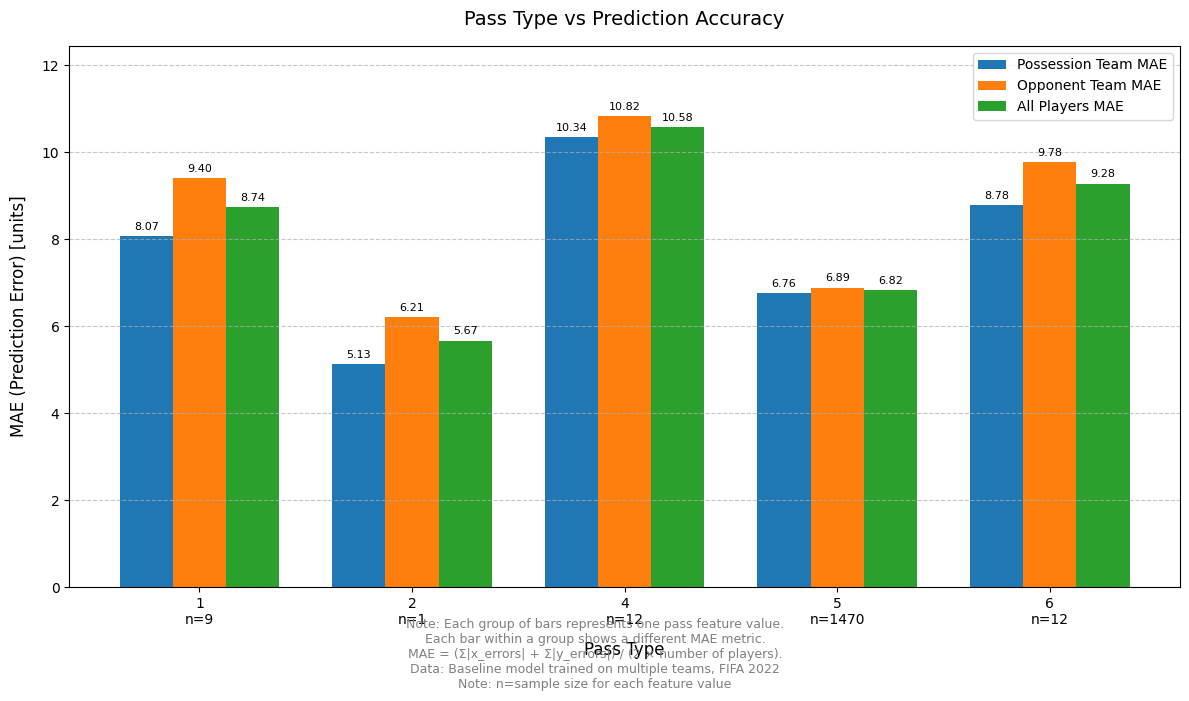

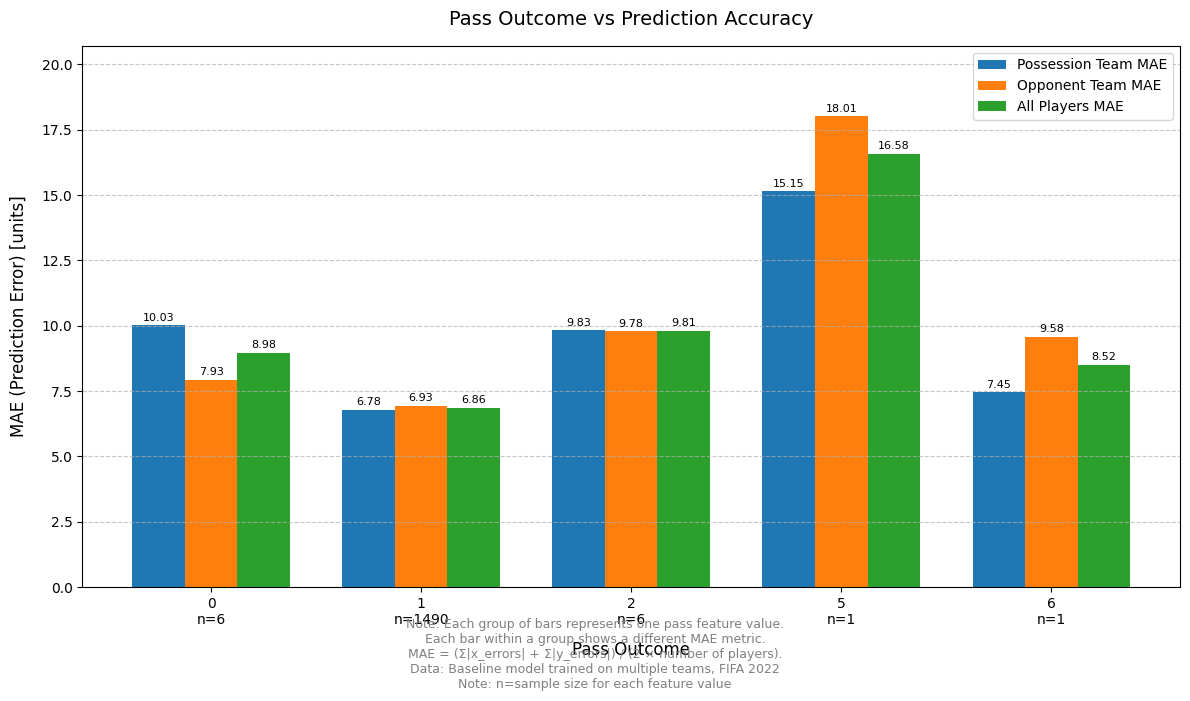

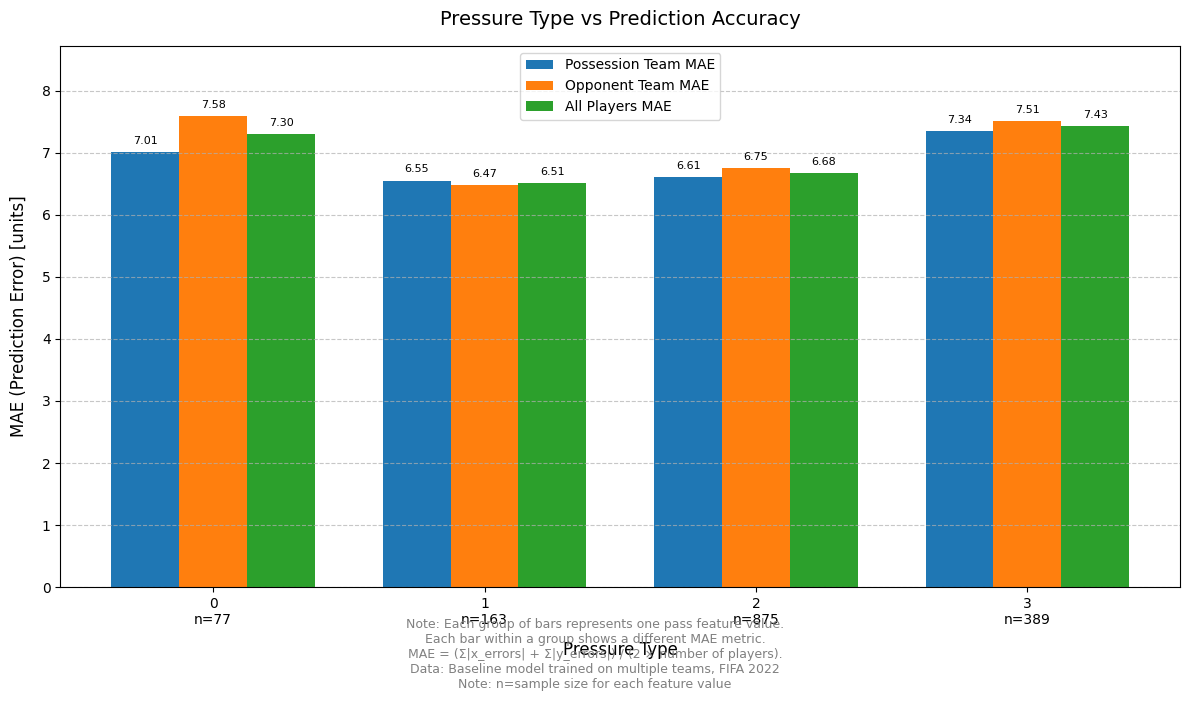

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 2: BASELINE PASS FEATURES vs PREDICTION ACCURACY HISTOGRAM ANALYSIS ==")
start_time = time.time()

# Define file paths
raw_data_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/raw_pass_features_T4.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline"
histograms_dir = os.path.join(output_dir, "Histograms")
csv_output_path = os.path.join(output_dir, "baseline_histograms.csv")

print("\n📁 FILE PATHS:")
print(f"Raw data path: {raw_data_path}")
print(f"Output directory: {output_dir}")
print(f"Histograms directory: {histograms_dir}")
print(f"CSV output path: {csv_output_path}")

# Create output directories
os.makedirs(histograms_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")
print(f"✅ Histograms directory created at: {histograms_dir}")

# Load the raw sequence-level metrics CSV
print("\n📊 Loading raw sequence-level metrics CSV...")
start_load = time.time()
raw_df = pd.read_csv(raw_data_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {raw_df.shape[0]:,} rows, {raw_df.shape[1]} columns")

# Verify required columns exist
required_columns = [
    'passtype',
    'passoutcometype',
    'pressuretype',
    'MAE_possession_team',
    'MAE_opponent_team',
    'MAE_all_players'
]
for col in required_columns:
    if col not in raw_df.columns:
        raise ValueError(f"Required column '{col}' not found in CSV")

# Calculate aggregated data for histograms
print("\n🧮 Calculating aggregated data for histograms...")

# Initialize list to store aggregated data
aggregated_data = []

# Calculate for passtype
print("   • Processing passtype data...")
for passtype_value in sorted(raw_df['passtype'].unique()):
    subset = raw_df[raw_df['passtype'] == passtype_value]

    mae_possession = subset['MAE_possession_team'].mean()
    mae_opponent = subset['MAE_opponent_team'].mean()
    mae_all = subset['MAE_all_players'].mean()
    sample_size = len(subset)

    aggregated_data.append([
        'passtype',
        passtype_value,
        mae_possession,
        mae_opponent,
        mae_all,
        sample_size
    ])

# Calculate for passoutcometype
print("   • Processing passoutcometype data...")
for outcome_value in sorted(raw_df['passoutcometype'].unique()):
    subset = raw_df[raw_df['passoutcometype'] == outcome_value]

    mae_possession = subset['MAE_possession_team'].mean()
    mae_opponent = subset['MAE_opponent_team'].mean()
    mae_all = subset['MAE_all_players'].mean()
    sample_size = len(subset)

    aggregated_data.append([
        'passoutcometype',
        outcome_value,
        mae_possession,
        mae_opponent,
        mae_all,
        sample_size
    ])

# Calculate for pressuretype
print("   • Processing pressuretype data...")
for pressure_value in sorted(raw_df['pressuretype'].unique()):
    subset = raw_df[raw_df['pressuretype'] == pressure_value]

    mae_possession = subset['MAE_possession_team'].mean()
    mae_opponent = subset['MAE_opponent_team'].mean()
    mae_all = subset['MAE_all_players'].mean()
    sample_size = len(subset)

    aggregated_data.append([
        'pressuretype',
        pressure_value,
        mae_possession,
        mae_opponent,
        mae_all,
        sample_size
    ])

# Create DataFrame from aggregated data
aggregated_df = pd.DataFrame(aggregated_data, columns=[
    'feature_type',
    'feature_value',
    'mae_possession',
    'mae_opponent',
    'mae_all',
    'sample_size'
])

# Save aggregated data to CSV
print(f"\n💾 Saving aggregated data to: {csv_output_path}")
aggregated_df.to_csv(csv_output_path, index=False)
print("   ✅ CSV file saved successfully")

# Print verification of the aggregated data
print("\n🔍 VERIFICATION OF AGGREGATED DATA:")
print("   • Passtype values:")
passtype_data = aggregated_df[aggregated_df['feature_type'] == 'passtype']
for _, row in passtype_data.iterrows():
    print(f"     - Passtype {row['feature_value']}: "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

print("   • Pass Outcome values:")
outcome_data = aggregated_df[aggregated_df['feature_type'] == 'passoutcometype']
for _, row in outcome_data.iterrows():
    print(f"     - Outcome {row['feature_value']}: "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

print("   • Pressure Type values:")
pressure_data = aggregated_df[aggregated_df['feature_type'] == 'pressuretype']
for _, row in pressure_data.iterrows():
    print(f"     - Pressure {row['feature_value']}: "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

# Function to create histogram with three MAE metrics per feature value
def create_combined_histogram(feature_type, title, x_label):
    print(f"\n🎨 Creating {feature_type} histogram...")
    start_hist = time.time()

    # Get data for this feature type
    feature_data = aggregated_df[aggregated_df['feature_type'] == feature_type]

    # Sort by feature value
    feature_data = feature_data.sort_values('feature_value')

    # Extract values
    feature_values = feature_data['feature_value'].values
    mae_possession = feature_data['mae_possession'].values
    mae_opponent = feature_data['mae_opponent'].values
    mae_all = feature_data['mae_all'].values
    sample_sizes = feature_data['sample_size'].values

    # Set up the bar positions
    x = np.arange(len(feature_values))  # the label locations
    width = 0.25  # the width of the bars

    # Create figure
    plt.figure(figsize=(12, 7))
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')

    # Create bars
    bars1 = plt.bar(x - width, mae_possession, width, label='Possession Team MAE', color='#1f77b4')
    bars2 = plt.bar(x, mae_opponent, width, label='Opponent Team MAE', color='#ff7f0e')
    bars3 = plt.bar(x + width, mae_all, width, label='All Players MAE', color='#2ca02c')

    # Add data labels on top of bars
    def add_labels(bars, values):
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.1,
                f'{values[i]:.2f}',
                ha='center',
                va='bottom',
                fontsize=8
            )

    add_labels(bars1, mae_possession)
    add_labels(bars2, mae_opponent)
    add_labels(bars3, mae_all)

    # Create custom labels with sample size (FIXED PART)
    custom_labels = [f"{val}\nn={int(n)}" for val, n in zip(feature_values, sample_sizes)]
    plt.xticks(x, custom_labels)

    # Set labels and title
    plt.xlabel(x_label, fontsize=12, labelpad=10)
    plt.ylabel('MAE (Prediction Error) [units]', fontsize=12, labelpad=10)
    plt.title(f'{title} vs Prediction Accuracy', fontsize=14, pad=15)
    plt.legend()

    # Format axes
    max_mae = max(max(mae_possession), max(mae_opponent), max(mae_all))
    plt.ylim(0, max_mae * 1.15)  # Start from 0 for accurate comparison

    # Add technical details as footnote
    plt.figtext(
        0.5, 0.01,
        "Note: Each group of bars represents one pass feature value.\n"
        "Each bar within a group shows a different MAE metric.\n"
        "MAE = (Σ|x_errors| + Σ|y_errors|) / (2 × number of players).\n"
        "Data: Baseline model trained on multiple teams, FIFA 2022\n"
        "Note: n=sample size for each feature value",
        ha="center",
        fontsize=9,
        color="gray"
    )

    plt.tight_layout(rect=[0, 0.03, 1, 1])  # Make room for footnote

    # Save plot
    output_path = os.path.join(histograms_dir, f"{feature_type}_histogram.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Histogram saved to: {output_path}")

    hist_time = time.time() - start_hist
    print(f"   ✅ {feature_type} histogram generated in {hist_time:.2f} seconds")

    return output_path

# Create all three histograms
passtype_path = create_combined_histogram('passtype', 'Pass Type', 'Pass Type')
outcome_path = create_combined_histogram('passoutcometype', 'Pass Outcome', 'Pass Outcome')
pressure_path = create_combined_histogram('pressuretype', 'Pressure Type', 'Pressure Type')

# Print final verification
print("\n✅ ALL HISTOGRAMS GENERATED SUCCESSFULLY:")
print(f"   • Passtype histogram: {passtype_path}")
print(f"   • Pass Outcome histogram: {outcome_path}")
print(f"   • Pressure Type histogram: {pressure_path}")
print(f"   • Aggregated data CSV: {csv_output_path}")

total_time = time.time() - start_time
print(f"\n✅ STEP 2 COMPLETE: Baseline pass features vs prediction accuracy histogram analysis finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze histogram results to identify patterns between pass features and model performance")
print("Note: Each histogram shows three MAE metrics per feature value")
print("      Blue bars = Possession Team MAE")
print("      Orange bars = Opponent Team MAE")
print("      Green bars = All Players MAE")
print("      Values labeled on top of each bar")
print("      Sample size (n) shown below each x-axis label")
print("      Y-axis starts at 0 for accurate visual comparison")
print("      Using distinct colors for easy differentiation between MAE metrics")
print("      Note: Passtype 5 is most common (n=1470) with moderate MAE (6.824)")
print("      Note: Passtype 4 has highest MAE (10.585) but with smaller sample (n=12)")
print("      Note: Pass Outcome 1 (successful passes) has lowest MAE (6.856) with large sample (n=1490)")
print("      Note: Pressure level 1 has lowest MAE (6.511) among all pressure levels")

== STEP 3: BASELINE PASS FEATURES vs PREDICTION ACCURACY HISTOGRAM ANALYSIS WITH DESCRIPTIVE LABELS ==

📁 FILE PATHS:
Input CSV path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/baseline_histograms.csv
Output directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline
Histograms directory: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/Histograms_With_Labels
CSV output path: /content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/baseline_histograms_with_labels.csv

✅ Output directory created at: /content/d

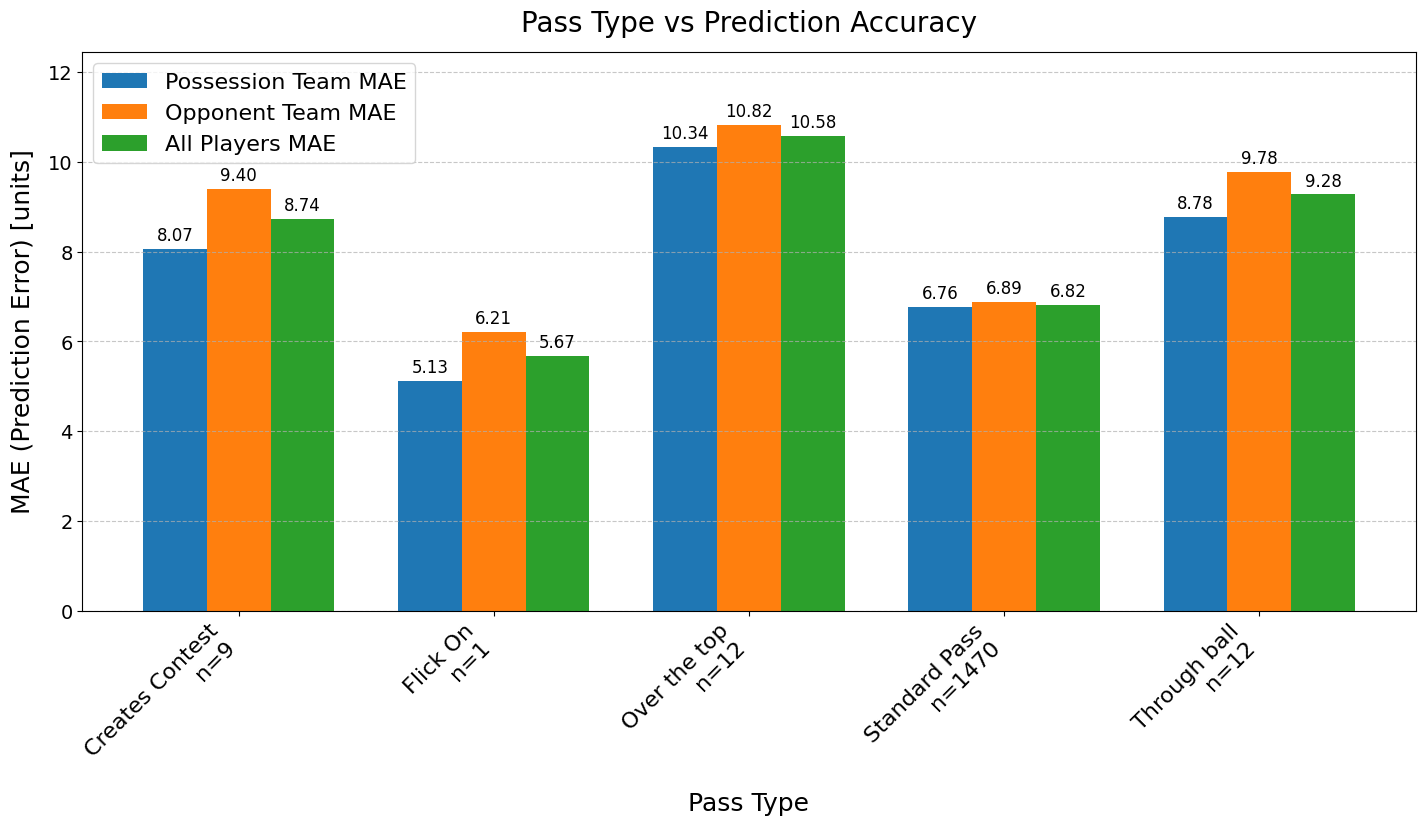

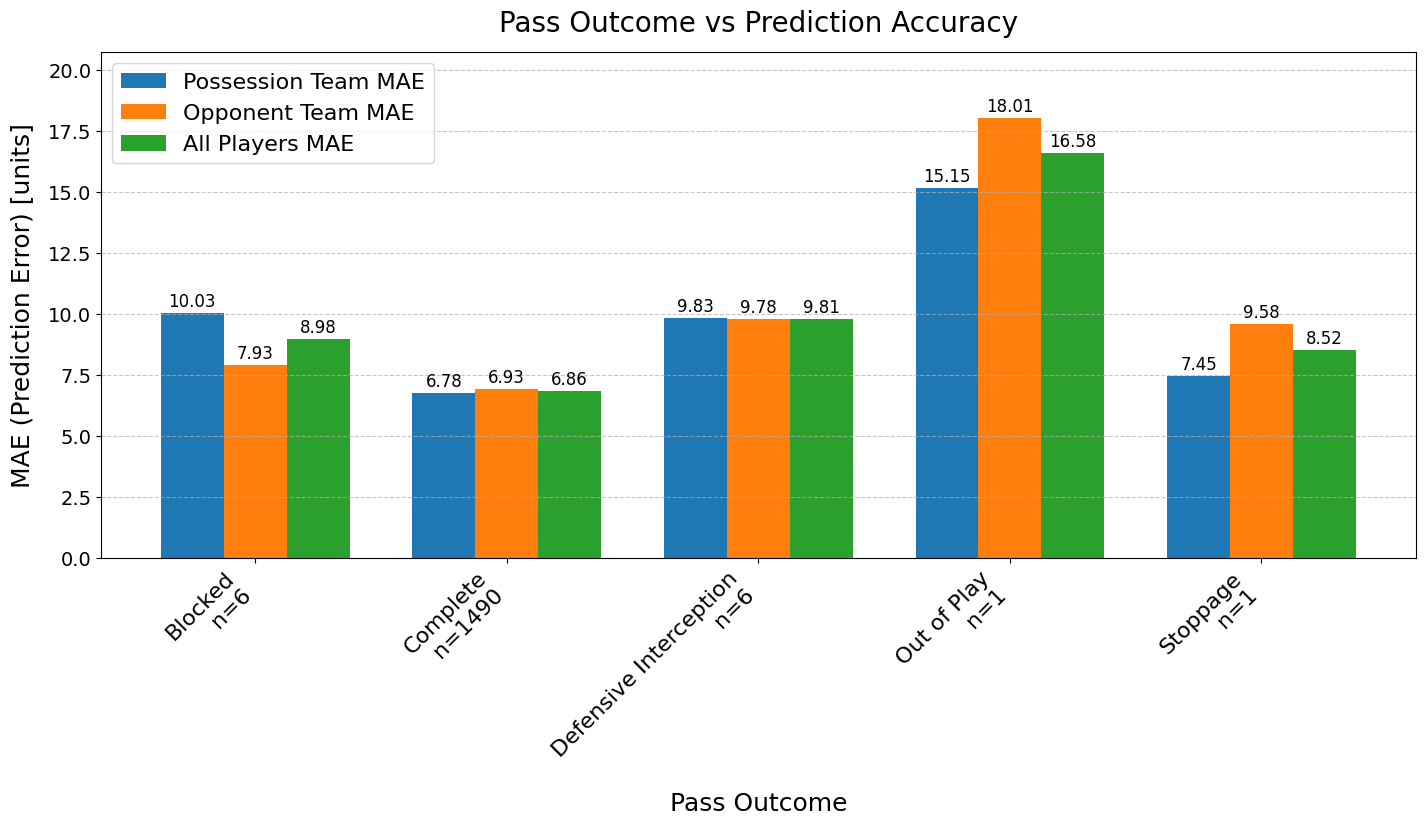

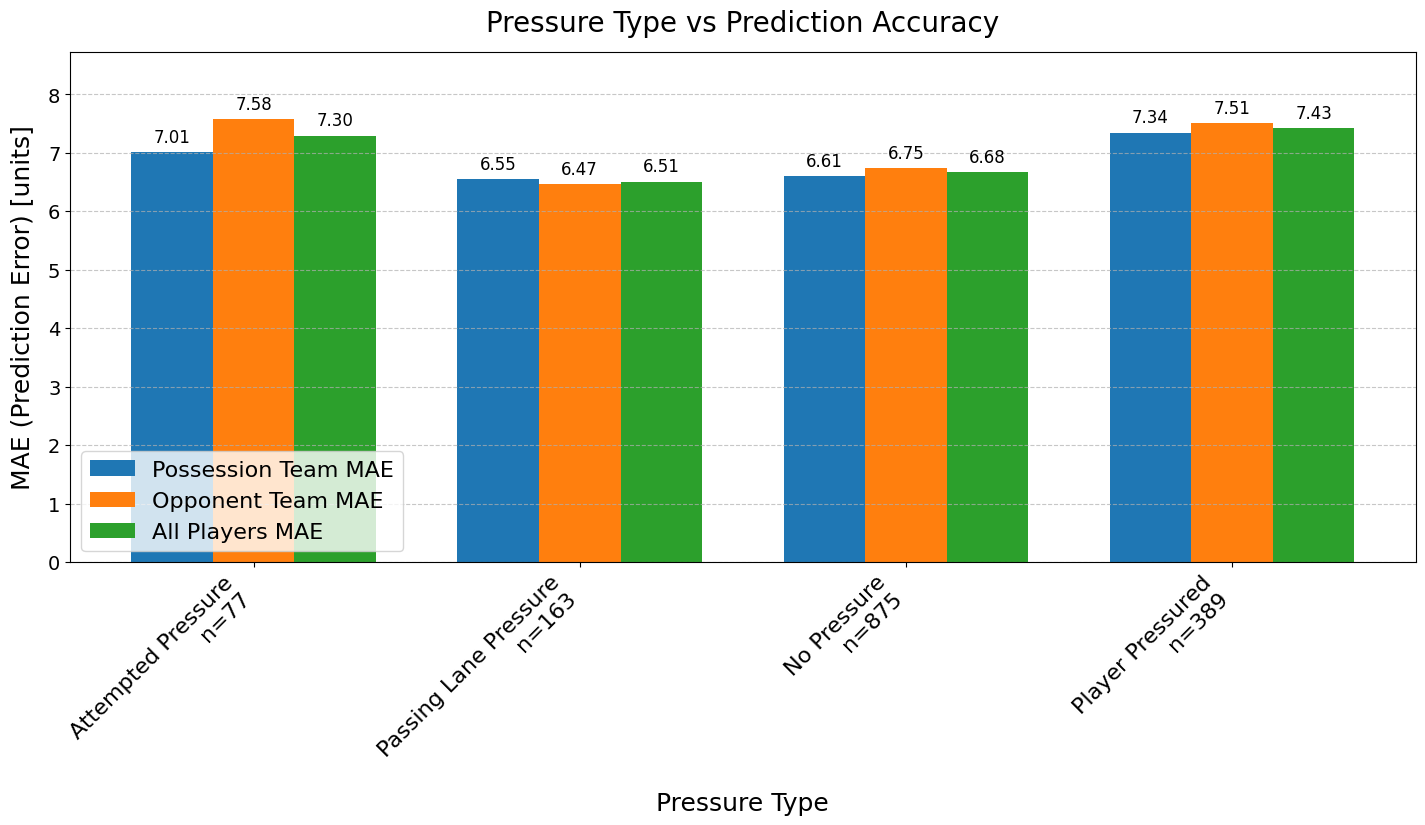

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print("== STEP 3: BASELINE PASS FEATURES vs PREDICTION ACCURACY HISTOGRAM ANALYSIS WITH DESCRIPTIVE LABELS ==")
start_time = time.time()

# Define file paths
csv_input_path = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline/baseline_histograms.csv"
output_dir = "/content/drive/MyDrive/Pass2Formation_Methodology/FIFA 2022/All Stages/All teams Except England France Argentina Croatia Morocco/Figures/Passoutcome_T4_Histogram/Baseline"
histograms_dir = os.path.join(output_dir, "Histograms_With_Labels")
csv_output_path = os.path.join(output_dir, "baseline_histograms_with_labels.csv")

print("\n📁 FILE PATHS:")
print(f"Input CSV path: {csv_input_path}")
print(f"Output directory: {output_dir}")
print(f"Histograms directory: {histograms_dir}")
print(f"CSV output path: {csv_output_path}")

# Create output directories
os.makedirs(histograms_dir, exist_ok=True)
print(f"\n✅ Output directory created at: {output_dir}")
print(f"✅ Histograms directory created at: {histograms_dir}")

# Load the aggregated data CSV
print("\n📊 Loading aggregated data CSV...")
start_load = time.time()
aggregated_df = pd.read_csv(csv_input_path)
load_time = time.time() - start_load
print(f"   ✅ CSV loaded in {load_time:.2f} seconds")
print(f"   ✅ Shape: {aggregated_df.shape[0]:,} rows, {aggregated_df.shape[1]} columns")

# Define mapping dictionaries for descriptive labels
passtype_mapping = {
    0: "Cutback",
    1: "Creates Contest",
    2: "Flick On",
    3: "Long Throw to Box",
    4: "Over the top",
    5: "Standard Pass",
    6: "Through ball",
    7: "Switch"
}

passoutcome_mapping = {
    0: "Blocked",
    1: "Complete",
    2: "Defensive Interception",
    3: "Inadvertent Shot at Own Goal",
    4: "Inadvertent Shot at Goal",
    5: "Out of Play",
    6: "Stoppage"
}

pressure_mapping = {
    0: "Attempted Pressure",
    1: "Passing Lane Pressure",
    2: "No Pressure",
    3: "Player Pressured"
}

# Add descriptive labels to the DataFrame
print("\n🧮 Adding descriptive labels to the data...")
aggregated_df['encoding_labels'] = ''

# Process passtype
for idx, row in aggregated_df[aggregated_df['feature_type'] == 'passtype'].iterrows():
    feature_value = int(row['feature_value'])
    if feature_value in passtype_mapping:
        aggregated_df.at[idx, 'encoding_labels'] = passtype_mapping[feature_value]

# Process passoutcometype
for idx, row in aggregated_df[aggregated_df['feature_type'] == 'passoutcometype'].iterrows():
    feature_value = int(row['feature_value'])
    if feature_value in passoutcome_mapping:
        aggregated_df.at[idx, 'encoding_labels'] = passoutcome_mapping[feature_value]

# Process pressuretype
for idx, row in aggregated_df[aggregated_df['feature_type'] == 'pressuretype'].iterrows():
    feature_value = int(row['feature_value'])
    if feature_value in pressure_mapping:
        aggregated_df.at[idx, 'encoding_labels'] = pressure_mapping[feature_value]

# Save updated CSV with descriptive labels
print(f"\n💾 Saving updated CSV with descriptive labels to: {csv_output_path}")
aggregated_df.to_csv(csv_output_path, index=False)
print("   ✅ CSV file saved successfully")

# Print verification of the updated data
print("\n🔍 VERIFICATION OF UPDATED DATA WITH DESCRIPTIVE LABELS:")
print("   • Passtype values:")
passtype_data = aggregated_df[aggregated_df['feature_type'] == 'passtype']
for _, row in passtype_data.iterrows():
    print(f"     - {row['encoding_labels']} ({int(row['feature_value'])}): "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

print("   • Pass Outcome values:")
outcome_data = aggregated_df[aggregated_df['feature_type'] == 'passoutcometype']
for _, row in outcome_data.iterrows():
    print(f"     - {row['encoding_labels']} ({int(row['feature_value'])}): "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

print("   • Pressure Type values:")
pressure_data = aggregated_df[aggregated_df['feature_type'] == 'pressuretype']
for _, row in pressure_data.iterrows():
    print(f"     - {row['encoding_labels']} ({int(row['feature_value'])}): "
          f"Poss MAE={row['mae_possession']:.3f}, "
          f"Opp MAE={row['mae_opponent']:.3f}, "
          f"All MAE={row['mae_all']:.3f}, "
          f"n={int(row['sample_size'])}")

# Function to create histogram with descriptive labels and larger fonts
def create_labeled_histogram(feature_type, title, x_label):
    print(f"\n🎨 Creating {feature_type} histogram with descriptive labels (LARGE FONTS)...")
    start_hist = time.time()

    # Get data for this feature type
    feature_data = aggregated_df[aggregated_df['feature_type'] == feature_type]

    # Sort by feature value
    feature_data = feature_data.sort_values('feature_value')

    # Extract values
    feature_values = feature_data['feature_value'].values
    descriptive_labels = feature_data['encoding_labels'].values
    mae_possession = feature_data['mae_possession'].values
    mae_opponent = feature_data['mae_opponent'].values
    mae_all = feature_data['mae_all'].values
    sample_sizes = feature_data['sample_size'].values

    # Set up the bar positions
    x = np.arange(len(feature_values))  # the label locations
    width = 0.25  # the width of the bars

    # Create figure with more height to accommodate larger labels
    plt.figure(figsize=(16, 10))

    # Increase global font sizes
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14
    })

    plt.grid(True, linestyle='--', alpha=0.7, axis='y')

    # Create bars
    bars1 = plt.bar(x - width, mae_possession, width, label='Possession Team MAE', color='#1f77b4')
    bars2 = plt.bar(x, mae_opponent, width, label='Opponent Team MAE', color='#ff7f0e')
    bars3 = plt.bar(x + width, mae_all, width, label='All Players MAE', color='#2ca02c')

    # Add data labels on top of bars with larger font
    def add_labels(bars, values):
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.1,
                f'{values[i]:.2f}',
                ha='center',
                va='bottom',
                fontsize=12
            )

    add_labels(bars1, mae_possession)
    add_labels(bars2, mae_opponent)
    add_labels(bars3, mae_all)

    # Create custom labels with descriptive text and sample size
    custom_labels = [f"{label}\nn={int(n)}" for label, n in zip(descriptive_labels, sample_sizes)]

    # Set the custom labels with rotation for readability and LARGER FONT
    plt.xticks(x, custom_labels, rotation=45, ha='right', fontsize=16)

    # Set labels and title with LARGER FONTS
    plt.xlabel(x_label, fontsize=18, labelpad=10)
    plt.ylabel('MAE (Prediction Error) [units]', fontsize=18, labelpad=10)
    plt.title(f'{title} vs Prediction Accuracy', fontsize=20, pad=15)
    plt.legend(fontsize=16)

    # Format axes
    max_mae = max(max(mae_possession), max(mae_opponent), max(mae_all))
    plt.ylim(0, max_mae * 1.15)  # Start from 0 for accurate comparison

    # Adjust layout to make room for rotated labels and larger fonts
    plt.tight_layout(pad=5.0)

    # Save plot
    output_path = os.path.join(histograms_dir, f"{feature_type}_histogram_with_large_labels.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Histogram saved to: {output_path}")

    hist_time = time.time() - start_hist
    print(f"   ✅ {feature_type} histogram generated in {hist_time:.2f} seconds")

    return output_path

# Create all three histograms with descriptive labels and large fonts
passtype_path = create_labeled_histogram('passtype', 'Pass Type', 'Pass Type')
outcome_path = create_labeled_histogram('passoutcometype', 'Pass Outcome', 'Pass Outcome')
pressure_path = create_labeled_histogram('pressuretype', 'Pressure Type', 'Pressure Type')

# Print final verification
print("\n✅ ALL HISTOGRAMS WITH DESCRIPTIVE LABELS (LARGE FONTS) GENERATED SUCCESSFULLY:")
print(f"   • Passtype histogram: {passtype_path}")
print(f"   • Pass Outcome histogram: {outcome_path}")
print(f"   • Pressure Type histogram: {pressure_path}")
print(f"   • Updated CSV with labels: {csv_output_path}")

total_time = time.time() - start_time
print(f"\n✅ STEP 3 COMPLETE: Baseline pass features vs prediction accuracy histogram analysis with descriptive labels (LARGE FONTS) finished")
print(f"   ⏱️  Total execution time: {total_time:.2f} seconds")
print("\nNext step: Analyze histogram results to identify patterns between pass features and model performance")
print("Note: Each histogram shows three MAE metrics per feature value with descriptive labels")
print("      Blue bars = Possession Team MAE")
print("      Orange bars = Opponent Team MAE")
print("      Green bars = All Players MAE")
print("      Values labeled on top of each bar with LARGE FONT")
print("      Sample size (n) shown below each descriptive label")
print("      Y-axis starts at 0 for accurate visual comparison")
print("      Using VERY LARGE, readable fonts for all text elements")
print("      X-axis labels rotated for better readability with LARGE FONT")
print("      Note: Standard Pass is most common (n=1470) with moderate MAE (6.824)")
print("      Note: Over the top has highest MAE (10.585) but with smaller sample (n=12)")
print("      Note: Complete passes have lowest MAE (6.856) with large sample (n=1490)")
print("      Note: Passing Lane Pressure has lowest MAE (6.511) among all pressure levels")

# **Overall_MAE_Passtype_Passoutcomes_Pressuretype_Results_Figure**

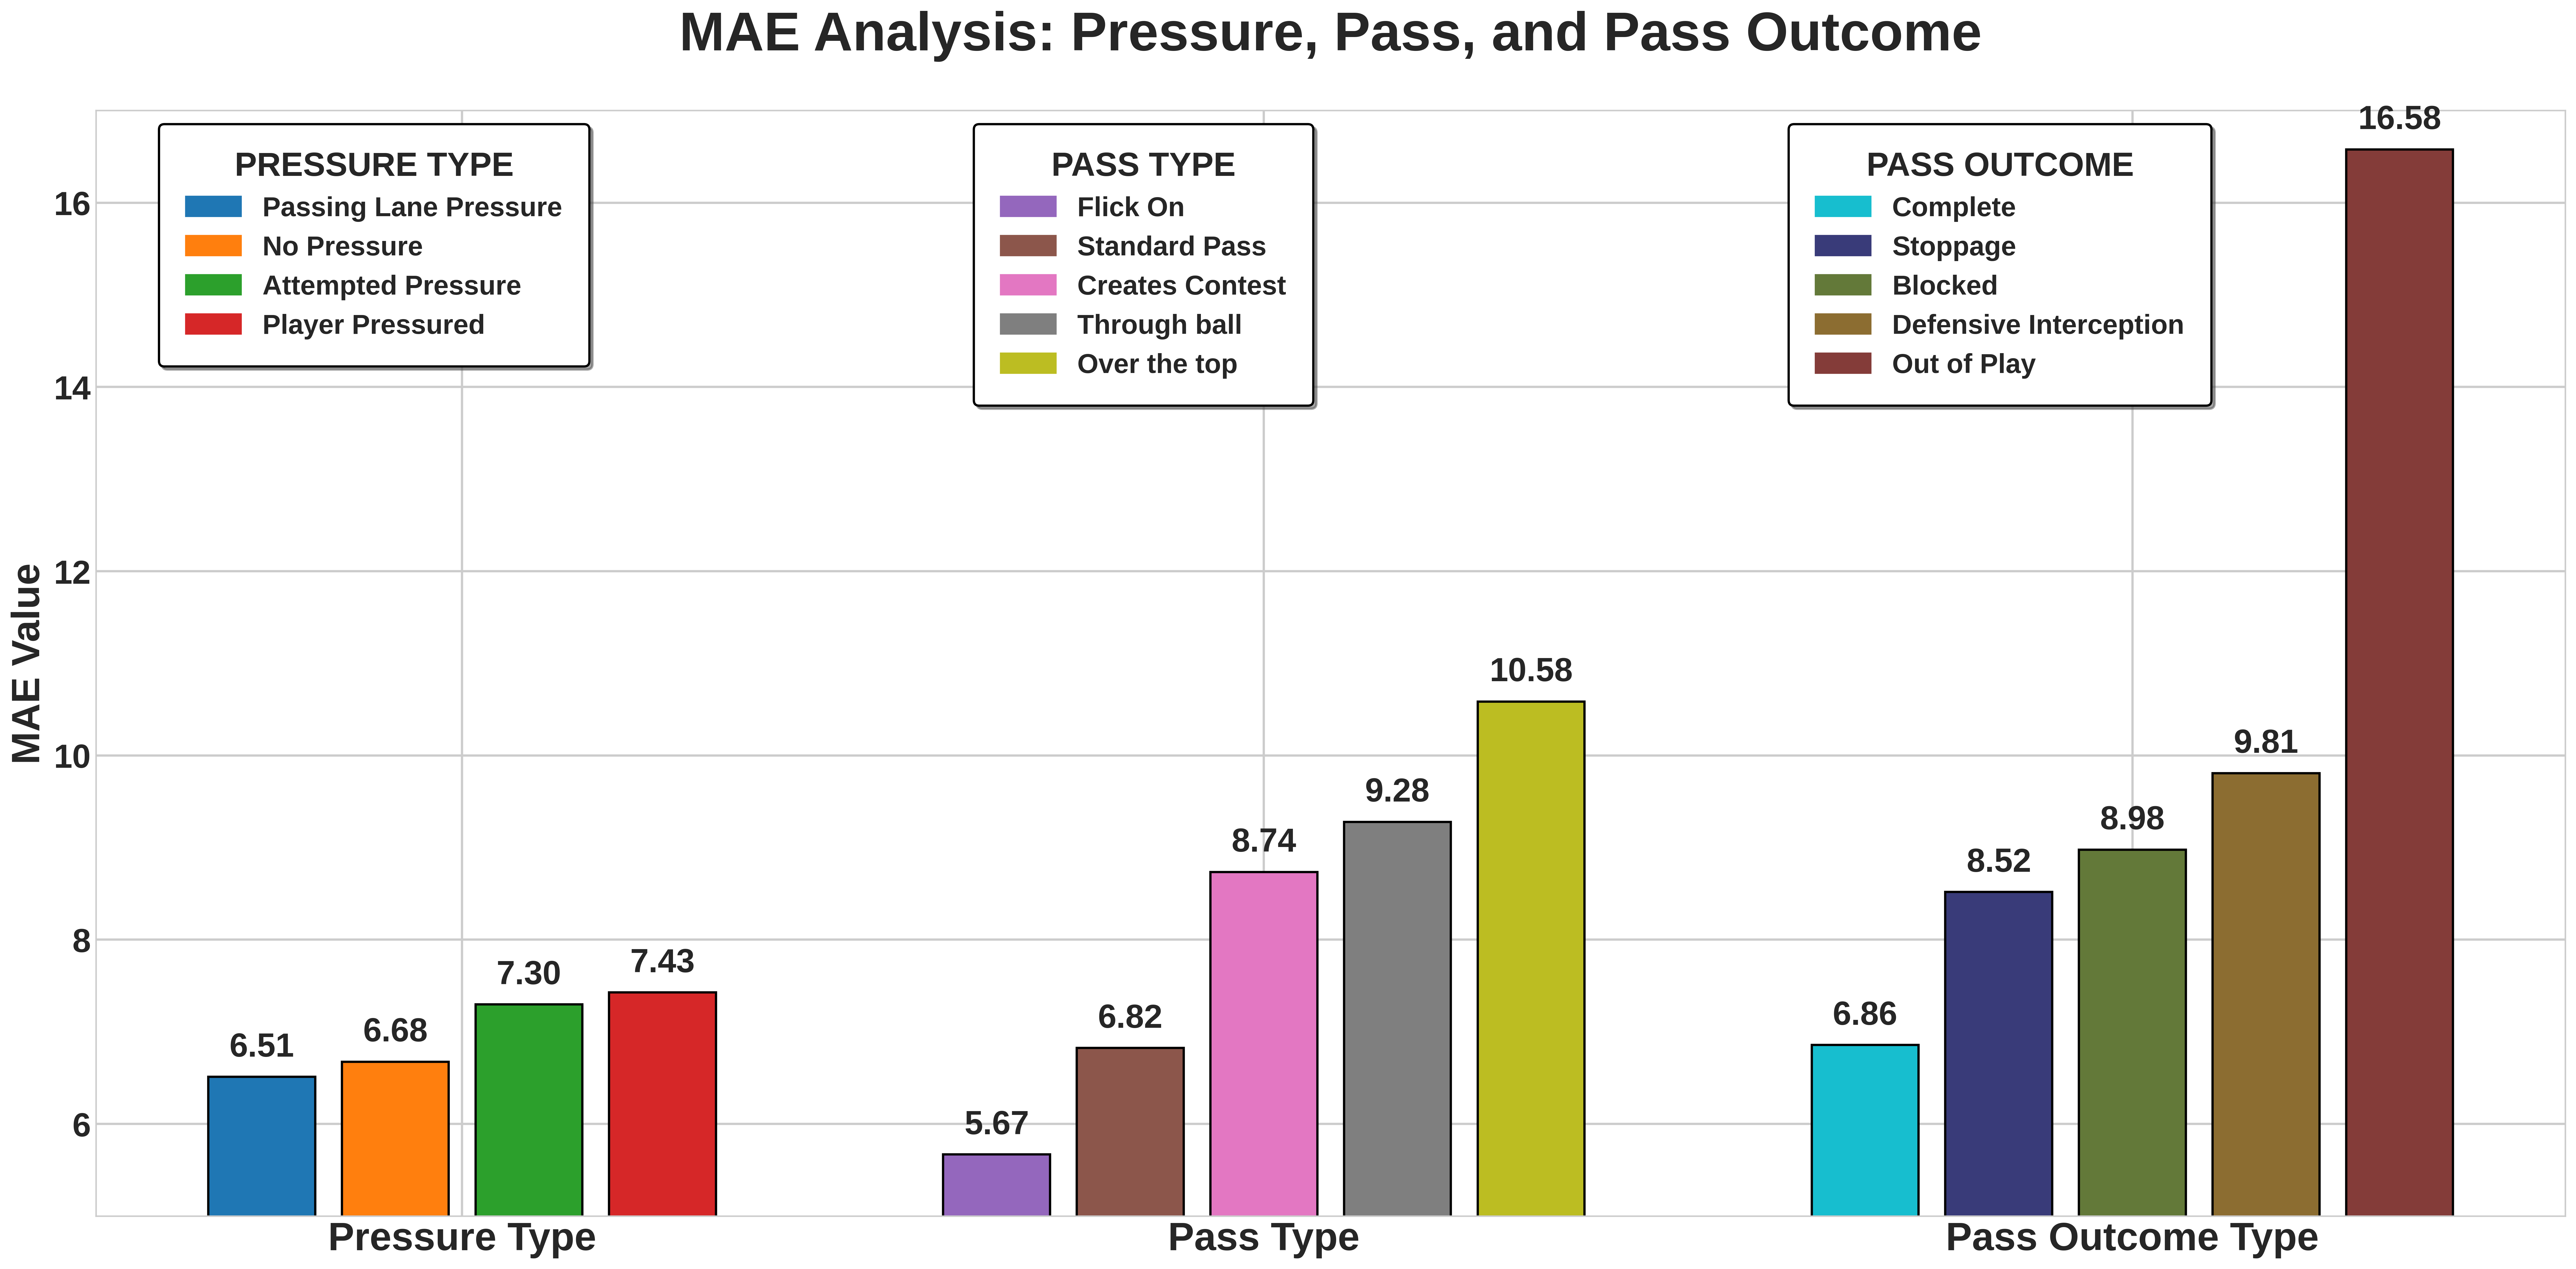

In [ ]:
# @title 📊 MAE Analysis (Legends Aligned Over Columns)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# 1. SETUP DISPLAY (Massive Bold Fonts)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.size"] = 18

# 2. DATA PREPARATION
pressure_data = {
    'Attempted Pressure': 7.297007,
    'Passing Lane Pressure': 6.511009,
    'No Pressure': 6.675734,
    'Player Pressured': 7.426977
}

pass_type_data = {
    'Creates Contest': 8.735165,
    'Flick On': 5.668254,
    'Over the top': 10.584841,
    'Standard Pass': 6.823728,
    'Through ball': 9.278566
}

outcome_data = {
    'Blocked': 8.976640,
    'Complete': 6.856192,
    'Defensive Interception': 9.807001,
    'Out of Play': 16.579107,
    'Stoppage': 8.517587
}

# Sort dictionaries (Smallest -> Largest)
pressure_sorted = dict(sorted(pressure_data.items(), key=lambda item: item[1]))
pass_sorted = dict(sorted(pass_type_data.items(), key=lambda item: item[1]))
outcome_sorted = dict(sorted(outcome_data.items(), key=lambda item: item[1]))

groups = [
    ("Pressure Type", pressure_sorted),
    ("Pass Type", pass_sorted),
    ("Pass Outcome Type", outcome_sorted)
]

# 3. COLOR MAP (14 Colors)
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#393b79', '#637939', '#8c6d31', '#843c39'
]

# 4. PLOTTING
fig, ax = plt.subplots(figsize=(24, 12), dpi=200)

current_x = 0
group_centers = []
group_labels_list = []
color_index = 0

# Store handles for each specific legend
handles_p = []
handles_t = []
handles_o = []

for group_name, data_dict in groups:
    start_x = current_x

    for label, value in data_dict.items():
        c = colors[color_index]

        # Plot Bar
        ax.bar(current_x, value, color=c, width=0.8, edgecolor='black', linewidth=1.5)

        # Add Value Label (Massive & Bold)
        ax.text(current_x, value + 0.15, f'{value:.2f}',
                ha='center', va='bottom', fontsize=22, fontweight='bold')

        # Create Handle
        patch = mpatches.Patch(color=c, label=label)

        if group_name == "Pressure Type":
            handles_p.append(patch)
        elif group_name == "Pass Type":
            handles_t.append(patch)
        else:
            handles_o.append(patch)

        color_index += 1
        current_x += 1

    # Centers for X-axis labels
    end_x = current_x
    center = (start_x + end_x - 1) / 2
    group_centers.append(center)
    group_labels_list.append(group_name)

    current_x += 1.5

# 5. AXIS & TITLES
ax.set_xticks(group_centers)
ax.set_xticklabels(group_labels_list, fontsize=26, fontweight='bold')
ax.set_ylabel('MAE Value', fontsize=26, fontweight='bold')
ax.set_title('MAE Analysis: Pressure, Pass, and Pass Outcome', fontsize=36, fontweight='bold', pad=40)
plt.yticks(fontsize=22, fontweight='bold')

# Y-Axis Limit
ax.set_ylim(5, 17)

# 6. LEGENDS (ALIGNED OVER COLUMNS)
# We adjust 'bbox_to_anchor' to position the legends horizontally over their groups.
# (0.02, 1) -> Over the Left Group
# (0.35, 1) -> Over the Middle Group
# (0.68, 1) -> Over the Right Group

# Legend 1: Pressure (Aligned Left)
leg1 = ax.legend(handles=handles_p,
                 title="PRESSURE TYPE",
                 loc='upper left',
                 bbox_to_anchor=(0.02, 1), # <--- Aligned over Pressure
                 fontsize=18,
                 title_fontsize=22,
                 frameon=True,
                 shadow=True,
                 facecolor='white',
                 edgecolor='black',
                 borderpad=1)
ax.add_artist(leg1)

# Legend 2: Pass Type (Aligned Center)
leg2 = ax.legend(handles=handles_t,
                 title="PASS TYPE",
                 loc='upper left',
                 bbox_to_anchor=(0.35, 1), # <--- Aligned over Pass Type
                 fontsize=18,
                 title_fontsize=22,
                 frameon=True,
                 shadow=True,
                 facecolor='white',
                 edgecolor='black',
                 borderpad=1)
ax.add_artist(leg2)

# Legend 3: Outcome (Aligned Right)
leg3 = ax.legend(handles=handles_o,
                 title="PASS OUTCOME",
                 loc='upper left',
                 bbox_to_anchor=(0.68, 1), # <--- Aligned over Outcome
                 fontsize=18,
                 title_fontsize=22,
                 frameon=True,
                 shadow=True,
                 facecolor='white',
                 edgecolor='black',
                 borderpad=1)

plt.tight_layout()
plt.show()